# Model Comparator

In this notebook, I will code some interesting functions to compare all models made to predict the KS system.

In [49]:
import numpy as np
import torch as th
import time
from scipy import stats
from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Some functions

In [45]:
def generatingdata(state_initial, length,sample_points,dt,final_time):
    """
    This function will generate data from the KS.py simulation
    
    input:
    - state_initial: the initial/current state of the system
    - length: the "physical" length of the domaine. 
              pay attention cuz this value will determine if the system is regular or chaotic
    - sample_points: the number of sample points on this length. It will be the size of the input in our system
    - dt: the time step of the simulation
    - final_time: the total time of simulation
    in this way, the number of iteraction of the simulation will final_time/dt
    
    
    output:
    - return: state_history, time_counter, position_x
    - print: state_history.shape et final_time
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    
    """
    ks = KS(L=length,N=sample_points,dt=dt) #class of the simulation
    total_iteractions = int(np.round(final_time/dt))
    print("Running for : ",final_time, 'seconds', 'with', total_iteractions, 'iteractions')
    time_counter = 0 
    action = np.zeros(1) # in this simulation, we will set actions=0
    state_history = np.matrix(state_initial) # We will stack in state_history at each time step
    
    current_state = state_initial
    for nt in range(total_iteractions): 
        current_state = ks.advance(current_state,action)
        state_history = np.vstack((state_history,current_state))
        time_counter = np.hstack((time_counter,(nt+1)*ks.dt))
        if nt==100:
          print('100th iteraction: ok')
        if nt==1000:
          print('1000th iteraction: ok')
        if nt==2500:
          print('2500th iteraction: ok')
        if nt==5000:
          print('5000th iteraction: ok')
        if nt==10000:
          print('10000th iteraction: ok')
        if nt==50000:
          print('50000th iteraction: ok')
        if nt==75000:
          print('75000th iteraction: ok')
        if nt==100000:
          print('100000th iteraction: ok')
    
    position_x=ks.x
    # Explore the results 
    print('The state_history shape is:', state_history.shape)
    print('The final time:', time_counter[-1])
    
    return state_history, time_counter, position_x

In [29]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [30]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [31]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [32]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [174]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        ddd=np.absolute(size_conv_time-steps_to_predict)
        if steps_to_predict<size_conv_time:
            past=current_state[:,:,steps_to_predict:size_conv_time]
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,0:ddd]=past
            current_state[:,:,ddd:]=y
        else:
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,:]=y[:,:,(steps_to_predict-size_conv_time):]

    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    #print('The true solution:')
    #drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    #print('The model solution:')
    #drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    #plt.plot(np.absolute(dif))
    #plt.title('Difference between prediction and true value')
    #plt.ylabel('Delta')
    #plt.xlabel('Time step')
    
    return prediction_model_np, y_true_np, np.absolute(dif)

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [34]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [37]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [38]:
cd ../ks-simulator/dataset1/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset1


In [39]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


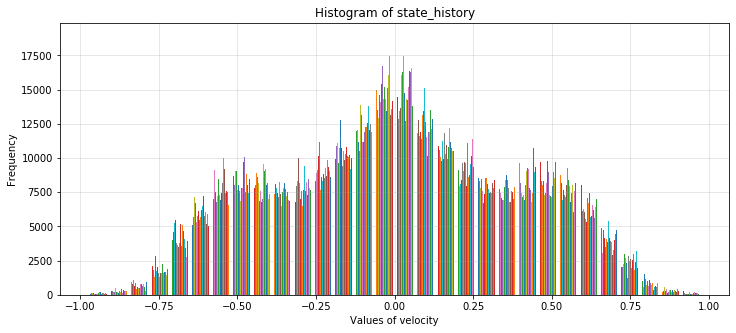

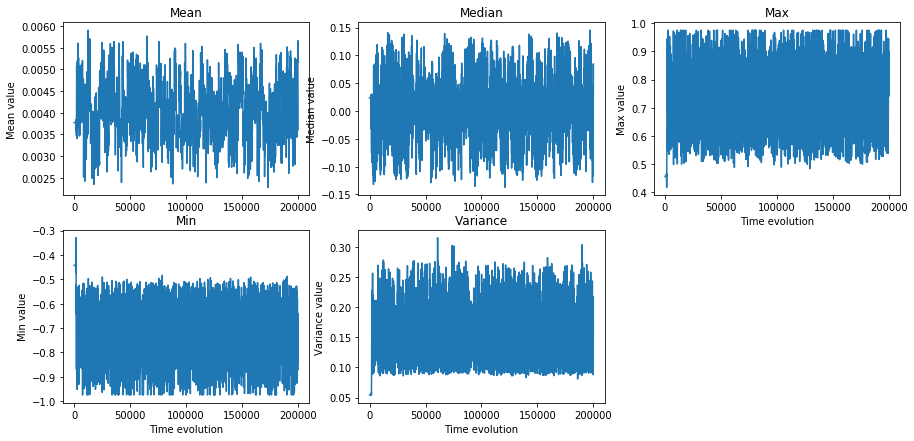

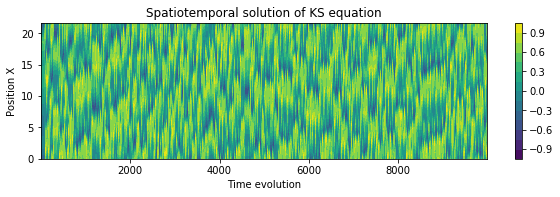

In [40]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=200000, width = 10, divwidth = 4)

In case it is necessary to decrease the data size:

In [37]:
#state_history_norm=state_history_norm[:50000,:]
state_history_norm.shape

(50000, 64)

## Comparing the evolution of many models in different start_positions

In [12]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [13]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


If you wanna see just a few positions, run the code below.

Setting the parameters:

In [77]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

Number_of_Models = 2

sp = [10,50] #steps_to_predict of the models
st = [100,150] #size_conv_time of the models

total_prediction = 1000


#positions to compare:

start_positions = np.array([200,3000,3500])

delta_all_models = np.zeros((Number_of_Models, total_prediction,start_positions.shape[0]))

The true solution:


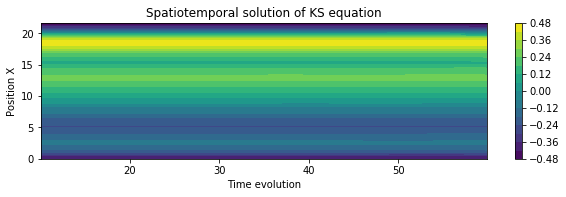

The model solution:


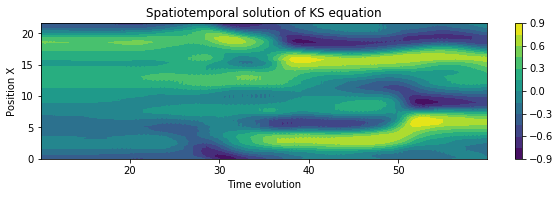

The true solution:


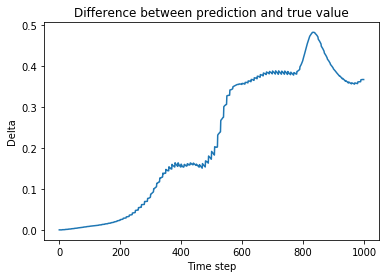

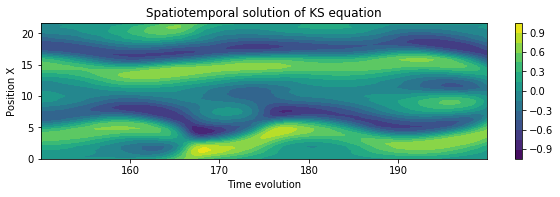

The model solution:


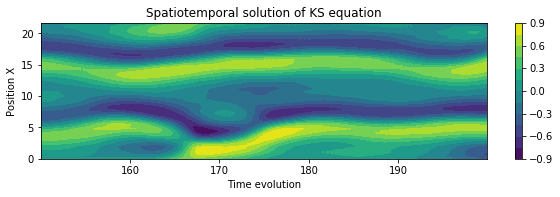

The true solution:


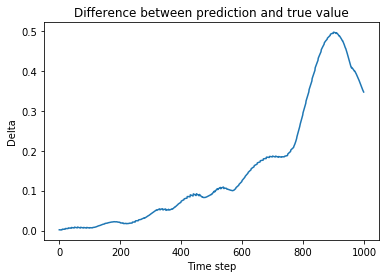

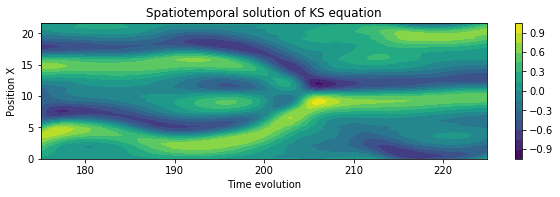

The model solution:


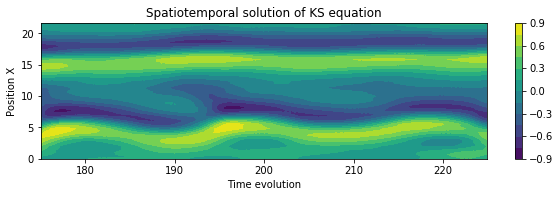

The true solution:


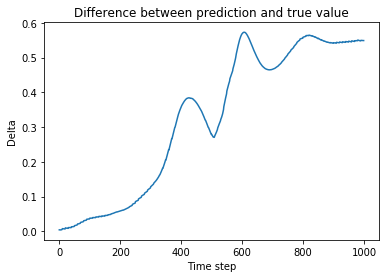

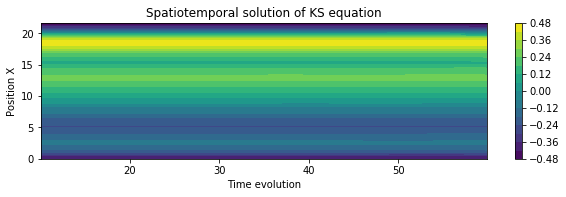

The model solution:


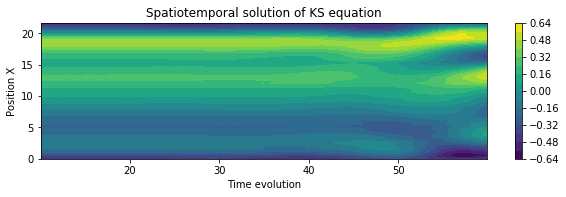

The true solution:


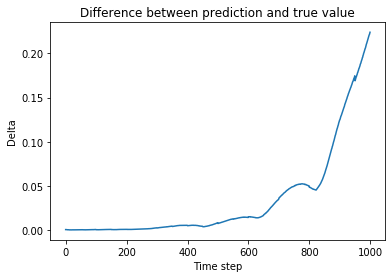

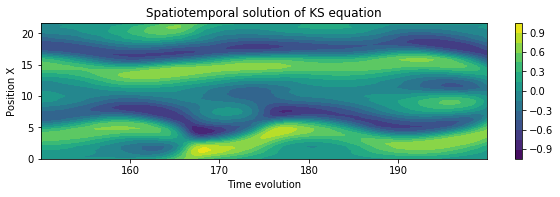

The model solution:


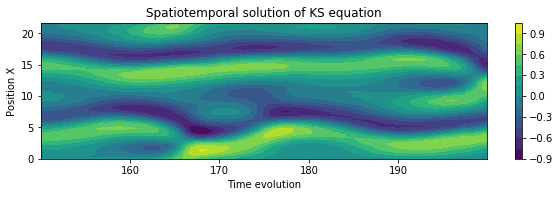

The true solution:


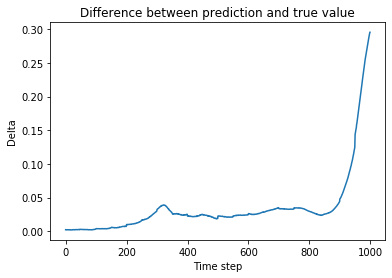

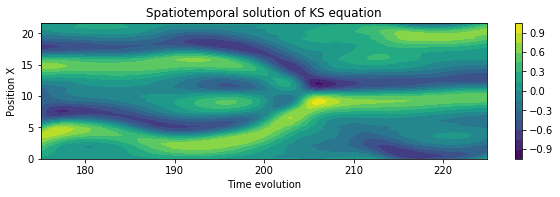

The model solution:


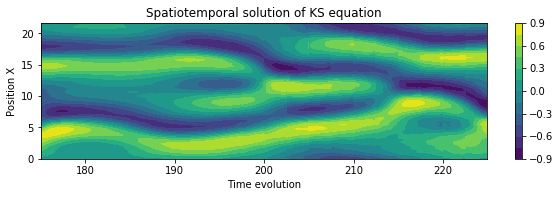

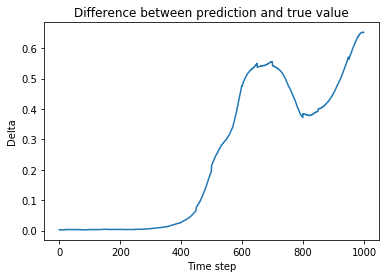

In [78]:
sp = [10,50] #steps_to_predict of the models
st = [100,150] #size_conv_time of the models

aux=0
for i in range(Number_of_Models):
    #TO LOAD THE MODEL.
    type_of_model="modelcv3"
    nmodel=str(i+1)
    train_set="u3"
    name = type_of_model + "_model" + nmodel + "_" + train_set
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    aux_1=0
    for ii in start_positions:
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos=ii
        N_step_simu=int(total_prediction/steps_to_predict)
        pp,yy, dif = prediction(model,pos,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        delta_all_models[i,:,aux_1] = dif
        aux_1=aux_1+1

Plotting the curves together:

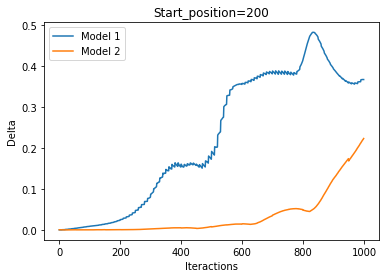

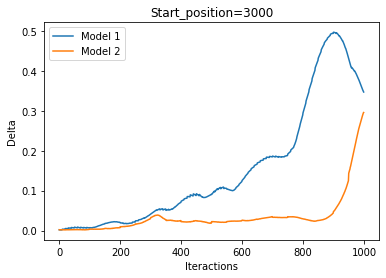

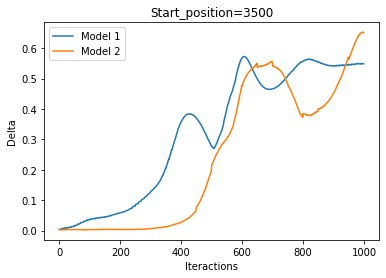

In [114]:
for iii in range(start_positions.shape[0]):
    plt.figure()
    labels = []
    for iiii in range(Number_of_Models):
        plt.plot(delta_all_models[iiii,:,iii])
        labels.append("Model "+str(iiii+1))
    plt.legend(labels)
    plt.ylabel('Delta')
    plt.xlabel('Iteractions')
    plt.title('Start_position='+str(start_positions[iii]))

If you want to look at several different positions and then average them, run the code below.

Setting the parameters:

In [14]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

Number_of_Models = 2

sp = [10,50] #steps_to_predict of the models
st = [100,150] #size_conv_time of the models

total_prediction = 1000

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=100000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2 = 100
startpoint_2 = 100000
finalpoint_2 = 185000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


delta_all_models_1 = np.zeros((Number_of_Models, total_prediction,start_positions_1.shape[0]))
delta_all_models_2 = np.zeros((Number_of_Models, total_prediction,start_positions_2.shape[0]))

In [15]:
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model="modelcv3"
    nmodel=str(i+1)
    train_set="u3"
    name = type_of_model + "_model" + nmodel + "_" + train_set
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        pp1,yy1,dif1 = prediction(model,pos_1,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,pos_2,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        delta_all_models_1[i,:,ii] = dif1
        delta_all_models_2[i,:,ii] = dif2
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Text(0.5, 1.0, 'Mean Error for test data')

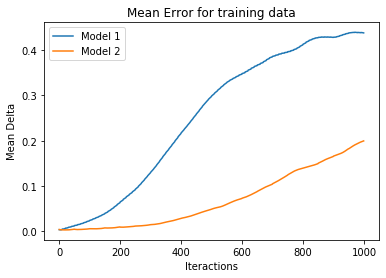

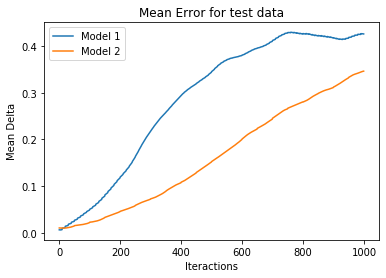

In [21]:
plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d1[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for training data')

plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d2[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for test data')

## Comparing the model with different training epochs

In [135]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [136]:
cd ../ks-simulator/differents_epochs/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\differents_epochs


In [133]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [142]:
size_conv_time=150
steps_to_predict=50

N_step_simu=100

Iteractions_Epochs = 34
delta_epochs = 5


#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


comparator_1 = np.zeros((Iteractions_Epochs,numberofpos_1))
comparator_2 = np.zeros((Iteractions_Epochs,numberofpos_2))

for i in range(Iteractions_Epochs):
    # Load the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states:
    #model=checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,ii] = np.mean(dif1)
        comparator_2[i,ii] = np.mean(dif2)
#taking the mean of all positions
c1=np.mean(comparator_1,axis=1)
c2=np.mean(comparator_2,axis=1)

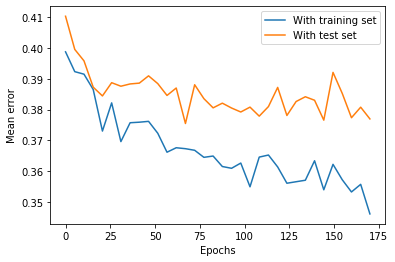

In [143]:
plt.figure()
plt.plot(np.linspace(0,Iteractions_Epochs*delta_epochs,Iteractions_Epochs),c1)
plt.plot(np.linspace(0,Iteractions_Epochs*delta_epochs,Iteractions_Epochs),c2)
plt.legend(['With training set', 'With test set'])
plt.ylabel('Mean error')
plt.xlabel('Epochs')
plt.show()

## Comparing the model with different history size

In [64]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [65]:
cd ../ks-simulator/different_history_size/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\different_history_size


In [66]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [68]:
Number_of_models = 10

#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

comparator_1 = np.zeros((Number_of_models,numberofpos_1))
comparator_2 = np.zeros((Number_of_models,numberofpos_2))

N_step_simu=100


for i in range(Number_of_models):
    
    size_conv_time = 10*(i+1)
    steps_to_predict=10
    
    # Load the states
    checkpoint = th.load(str(i)+str(i)+str(i))
    # restore the model and optimizer states:
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,ii] = np.mean(dif1)
        comparator_2[i,ii] = np.mean(dif2)
#taking the mean of all positions
c1=np.mean(comparator_1,axis=1)
c2=np.mean(comparator_2,axis=1)



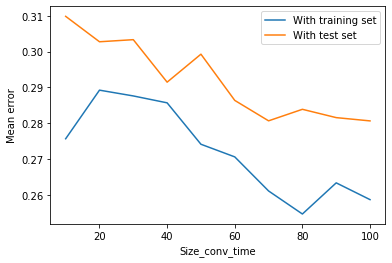

In [69]:
plt.figure()
plt.plot(np.linspace(10,100,10),c1)
plt.plot(np.linspace(10,100,10),c2)
plt.legend(['With training set', 'With test set'])
plt.ylabel('Mean error')
plt.xlabel('Size_conv_time')
plt.show()

In [49]:
#I=np.zeros((Number_of_models))
for i in range(Number_of_models):
# Load the states
    checkpoint = th.load(str(i)+str(i))
    # restore the model and optimizer states:
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    print(model)

Sequential(
  (0): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=256, out_features=320, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=320, out_features=640, bias=True)
  (10): Tanh()
)
Sequential(
  (0): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=9, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(i

## Comparing the model with different steps_to_predict

In [22]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [23]:
cd ../ks-simulator/different_steps_to_predict/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\different_steps_to_predict


In [19]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [26]:
Number_of_models = 10

#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

comparator_1 = np.zeros((Number_of_models,numberofpos_1))
comparator_2 = np.zeros((Number_of_models,numberofpos_2))


size_conv_time=150
N_step_simu=100

for i in range(Number_of_models):
    steps_to_predict=5*(i+1)
    #N_step_simu=int(1000/steps_to_predict)
    Lin = size_conv_time
    in_ch_conv_1 = 64
    out_ch_conv_1 = 128
    k_conv_1 = 4
    st_conv_1 = 2
    pad_conv_1 = 4
    L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1
    k_pool_1= 2
    st_pool_1= 2
    L_3 = (L_2 - k_pool_1)/st_pool_1 + 1
    in_ch_conv_2 = 128
    out_ch_conv_2 = 64
    k_conv_2 = 5
    st_conv_2 = 2
    pad_conv_2 = 1
    L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1
    k_pool_2= 5
    st_pool_2= 2
    L_5 = (L_4 - k_pool_2)/st_pool_2 + 1
    in_lin = int(sample_points*L_5)
    hidden_1 = sample_points*25
    out_lin = sample_points*steps_to_predict
    model = th.nn.Sequential(
        th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_1,st_pool_1),
        th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_2,st_pool_2),
        th.nn.Flatten(),
        th.nn.Linear(in_lin,hidden_1),
        th.nn.LeakyReLU(),
        th.nn.Linear(hidden_1,out_lin),
        th.nn.Tanh(),
    )
    model.double()
    model.cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
    loss_fn=th.nn.MSELoss()
    
    # Load the pickle file to read the dictionnary from the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states: 
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,ii] = np.mean(dif1)
        comparator_2[i,ii] = np.mean(dif2)
#taking the mean of all positions
c1=np.mean(comparator_1,axis=1)
c2=np.mean(comparator_2,axis=1)

In [22]:
comparator.shape

(10, 1)

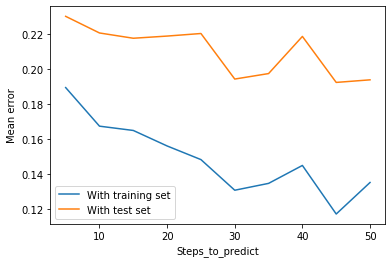

In [25]:
#Constant total time of simulation

plt.figure()
plt.plot(np.linspace(5,50,10),c1)
plt.plot(np.linspace(5,50,10),c2)
plt.legend(['With training set', 'With test set'])
plt.ylabel('Mean error')
plt.xlabel('Steps_to_predict')
plt.show()

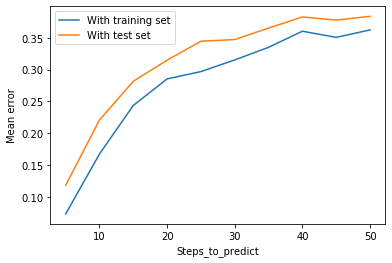

In [27]:
# N_step_simu = const
plt.figure()
plt.plot(np.linspace(5,50,10),c1)
plt.plot(np.linspace(5,50,10),c2)
plt.legend(['With training set', 'With test set'])
plt.ylabel('Mean error')
plt.xlabel('Steps_to_predict')
plt.show()

## Testing if the model can predict different datasets

In [13]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [14]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [16]:
size_conv_time=150
steps_to_predict=50

# Load the the model
checkpoint = th.load("modelcv3_model2_u3")

# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

In [17]:
Number_of_Datasets = 4

N_step_simu = 60

total_prediction = N_step_simu*steps_to_predict

#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

comparator_1 = np.zeros((Number_of_Datasets, total_prediction, numberofpos_1))
comparator_2 = np.zeros((Number_of_Datasets, total_prediction, numberofpos_2))

In [18]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [19]:
cd ../ks-simulator/dataset3/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset3


In [20]:
#load dataset
datasetnames=['u1','u2','u3','u4']

for i in range(Number_of_Datasets):
    print(datasetnames[i])
    state_history = np.loadtxt('state_history_3_'+ datasetnames[i] +'.dat')
    time_counter = np.loadtxt('time_counter_3_'+ datasetnames[i] +'.dat')
    position_x = np.loadtxt('position_3_'+datasetnames[i]+'.dat')
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
    state_history_norm = min_max_scaler.fit_transform(state_history)
    state_history_norm_th = th.from_numpy(state_history_norm).cuda()
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,:,ii] = dif1
        comparator_2[i,:,ii] = dif2
#taking the mean of all positions
c1=np.mean(comparator_1,axis=2)
c2=np.mean(comparator_2,axis=2)

u1
u2
u3
u4


In [ ]:
#DATASET1

colors = ['red','blue','black','yellow']
legends = ['Dataset1_u1 (not used to train)','Dataset1_u2 (not used to train)','Dataset1_u3 (training set)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.title('With the training part of Dataset1_u3')
plt.show()

legends = ['Dataset1_u1 (not used to train)','Dataset1_u2 (not used to train)','Dataset1_u3 (test set)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.title('With the test part of Dataset1_u3')
plt.show()

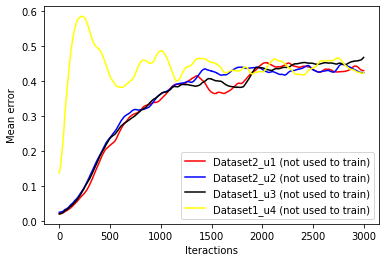

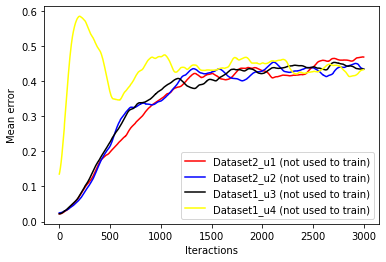

In [74]:
#DATASET2

colors = ['red','blue','black','yellow']
legends = ['Dataset2_u1 (not used to train)','Dataset2_u2 (not used to train)','Dataset1_u3 (not used to train)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.show()

legends = ['Dataset2_u1 (not used to train)','Dataset2_u2 (not used to train)','Dataset1_u3 (not used to train)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.show()

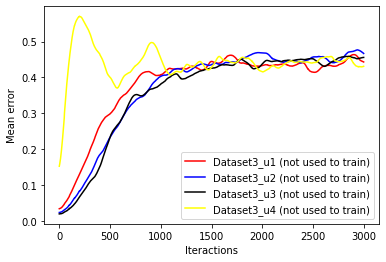

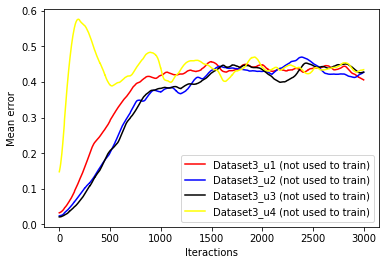

In [21]:
#DATASET3

colors = ['red','blue','black','yellow']
legends = ['Dataset3_u1 (not used to train)','Dataset3_u2 (not used to train)','Dataset3_u3 (not used to train)','Dataset3_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.show()

legends = ['Dataset3_u1 (not used to train)','Dataset3_u2 (not used to train)','Dataset3_u3 (not used to train)','Dataset3_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('Mean error')
plt.xlabel('Iteractions')
plt.show()

## Comparing the prediction of the model and simulators for the data generated by  the model

In [41]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [42]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [197]:
size_conv_time=150
steps_to_predict=50

# Load the the model
checkpoint = th.load("modelcv3_model2_u3")

# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

In [198]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

Number_of_Models = 1

total_prediction = 1500

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=100000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2 = 100
startpoint_2 = 100000
finalpoint_2 = 185000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


delta_all_models_1 = np.zeros((Number_of_Models, total_prediction,start_positions_1.shape[0]))
delta_all_models_2 = np.zeros((Number_of_Models, total_prediction,start_positions_2.shape[0]))

statespred1 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0])) #to save directly the prediction
statespred2 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0])) #to save directly the true value

In [199]:
dif1.shape

(150,)

In [200]:
for ii in range(start_positions_1.shape[0]):
    pos_1=int(start_positions_1[ii])
    pos_2=int(start_positions_2[ii])
    N_step_simu=int(total_prediction/steps_to_predict)
    vvv=int(size_conv_time/steps_to_predict)
    for i in range(int(N_step_simu/vvv)):
        if i==0:
            pp1,yy1,dif1 = prediction(model,pos_1,vvv,steps_to_predict,size_conv_time,state_history_norm_th)
            pp2,yy2,dif2 = prediction(model,pos_2,vvv,steps_to_predict,size_conv_time,state_history_norm_th)
            delta_all_models_1[0,i*steps_to_predict:(i+1)*steps_to_predict*vvv,ii] = dif1
            delta_all_models_2[0,i*steps_to_predict:(i+1)*steps_to_predict*vvv,ii] = dif2
            statespred1[0:size_conv_time,:,ii]=pp1
            statespred2[0:size_conv_time,:,ii]=yy1
            
        else:
            pos_1 = size_conv_time
            pos_2 = size_conv_time
            state_history1, time_counter, position_x = generatingdata(pp1[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)
            state_history2, time_counter, position_x = generatingdata(pp2[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)
            state_history1 = th.from_numpy(state_history1)
            state_history2 = th.from_numpy(state_history2)
            
            pp1,yy1,dif1 = prediction(model,pos_1,vvv,steps_to_predict,size_conv_time,state_history1)
            pp2,yy2,dif2 = prediction(model,pos_2,vvv,steps_to_predict,size_conv_time,state_history2)
            delta_all_models_1[0,i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,ii] = dif1
            delta_all_models_2[0,i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,ii] = dif2
            statespred1[i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,:,ii]=pp1
            statespred2[i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,:,ii]=yy1
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The prediction


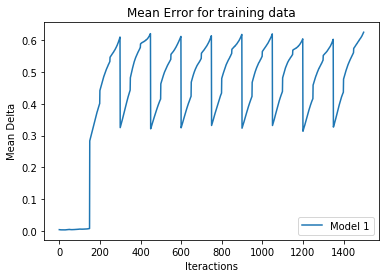

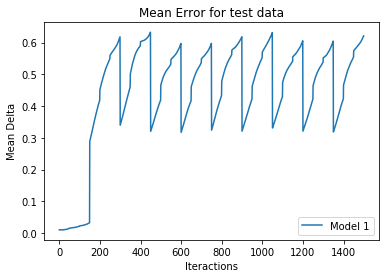

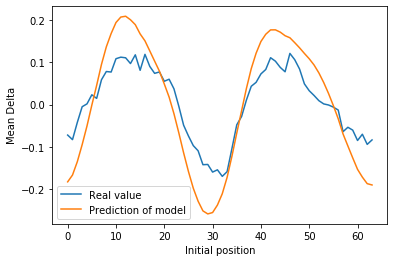

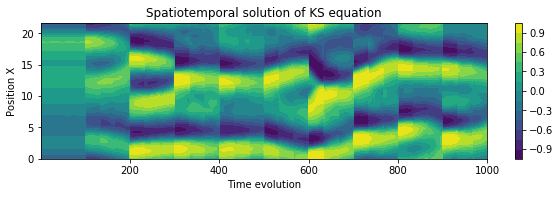

The true value


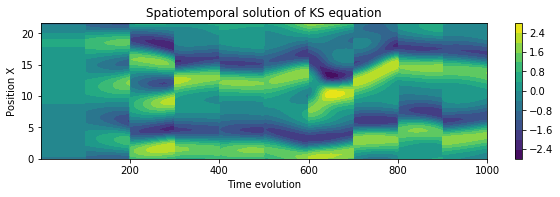

In [201]:
plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d1[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for training data')

plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d2[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for test data')

n1 = np.mean(statespred1,axis=0)
n1 = np.mean(n1,axis=1)
n11 = np.mean(statespred2,axis=0)
n11 = np.mean(n11,axis=1)

plt.figure()

plt.plot(n1)
plt.plot(n11)
plt.legend(['Real value','Prediction of model'])
plt.ylabel('Mean Delta')
plt.xlabel('Initial position')


time_counter=np.linspace(0,1000,1500)
#KSflow
print('The prediction')
drawKS(statespred1[:,:,0], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
print('The true value')
drawKS(statespred2[:,:,0], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)


The prediction


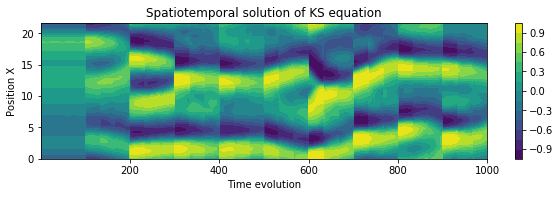

The true value


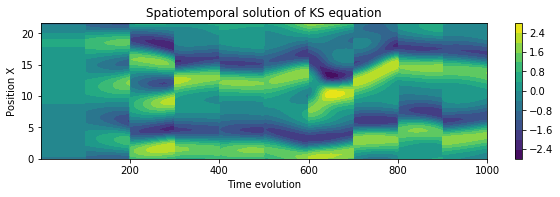

###################################
The prediction


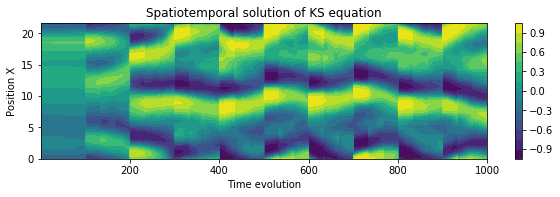

The true value


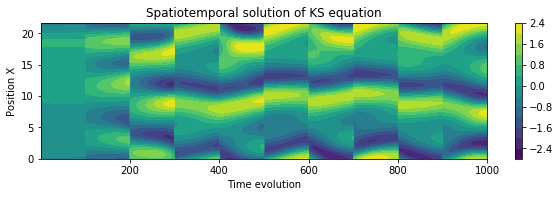

###################################
The prediction


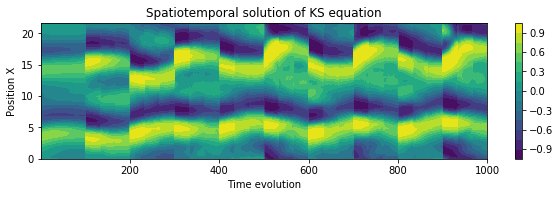

The true value


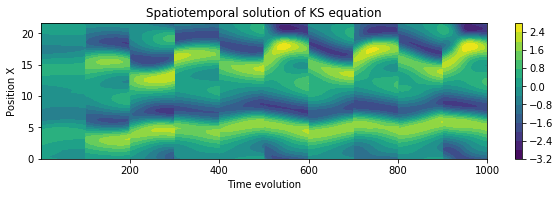

###################################
The prediction


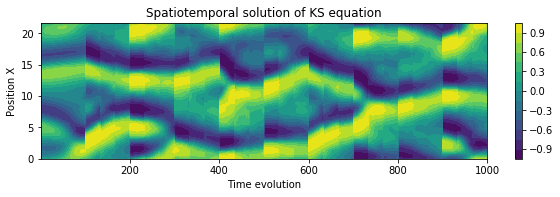

The true value


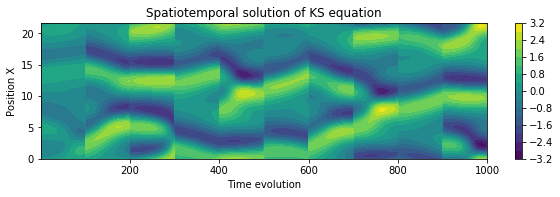

###################################
The prediction


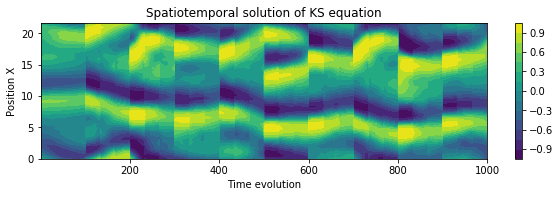

The true value


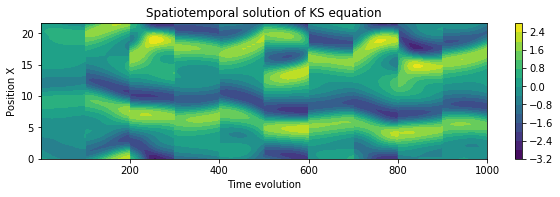

###################################
The prediction


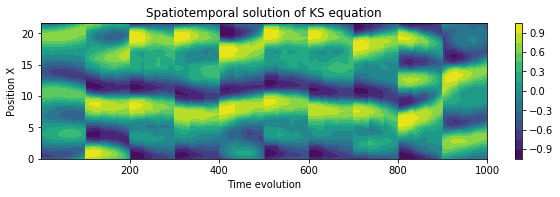

The true value


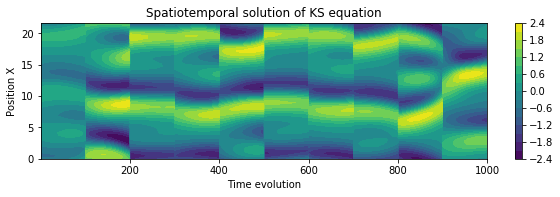

###################################
The prediction


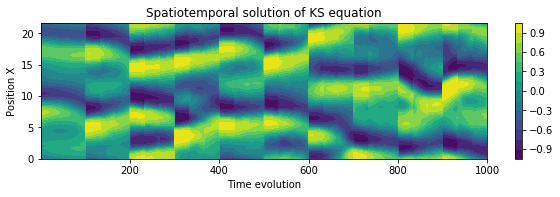

The true value


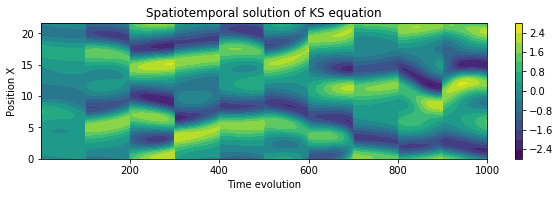

###################################
The prediction


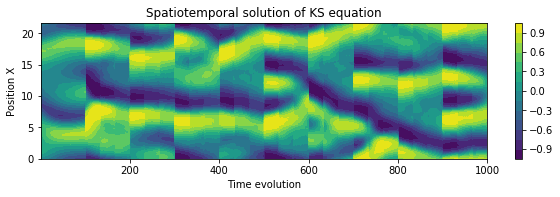

The true value


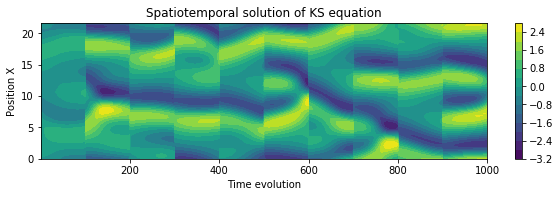

###################################
The prediction


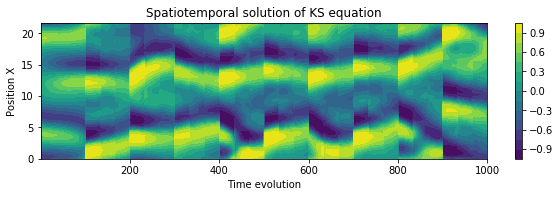

The true value


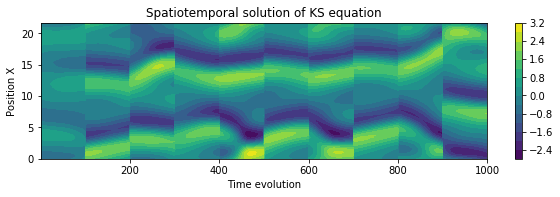

###################################
The prediction


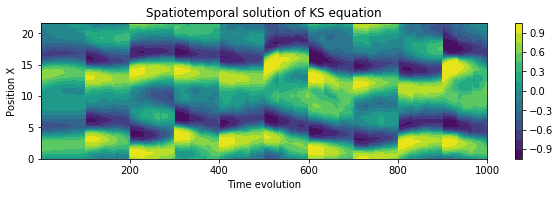

The true value


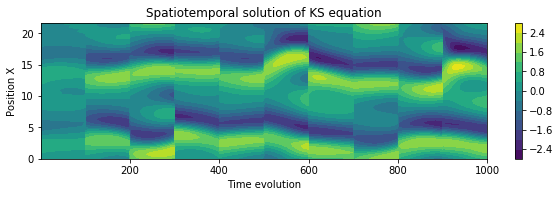

###################################
The prediction


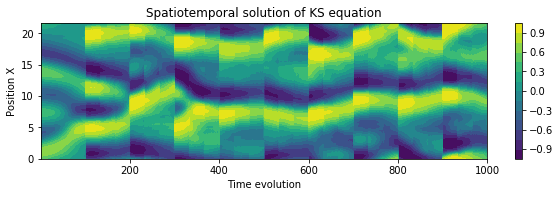

The true value


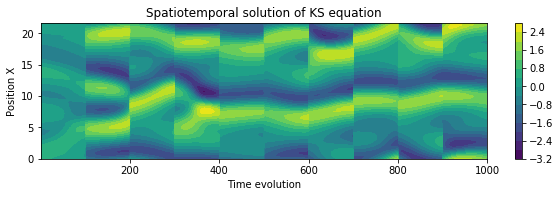

###################################
The prediction


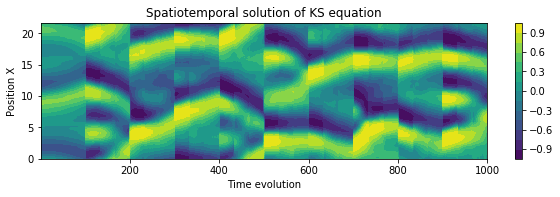

The true value


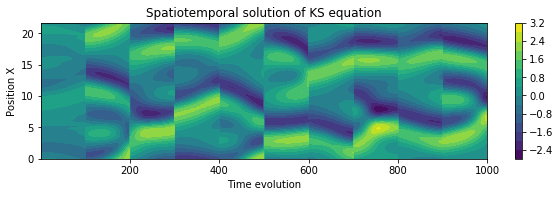

###################################
The prediction


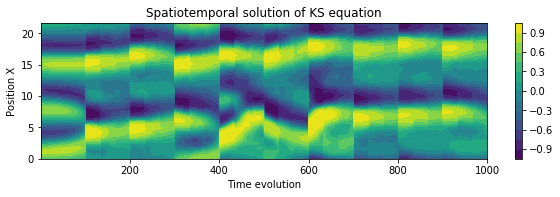

The true value


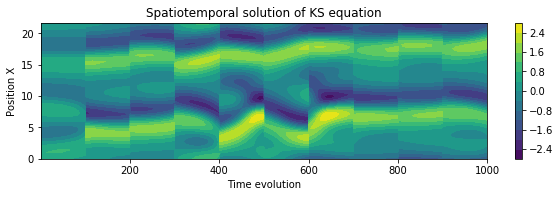

###################################
The prediction


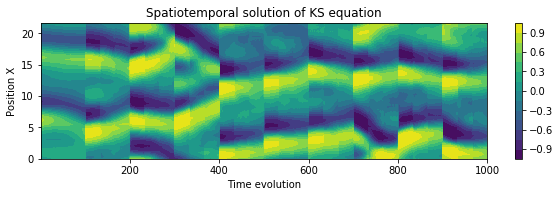

The true value


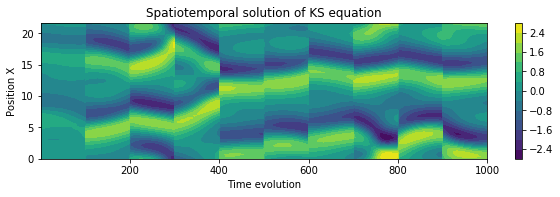

###################################
The prediction


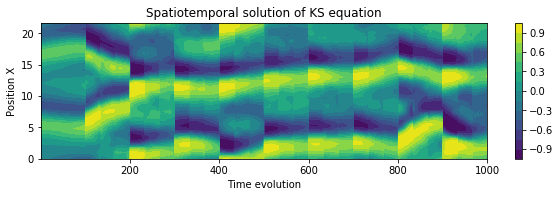

The true value


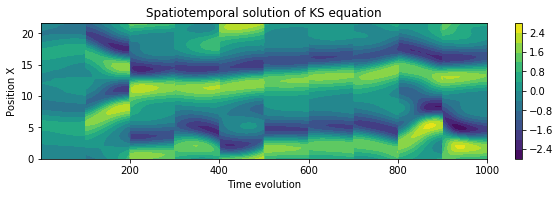

###################################
The prediction


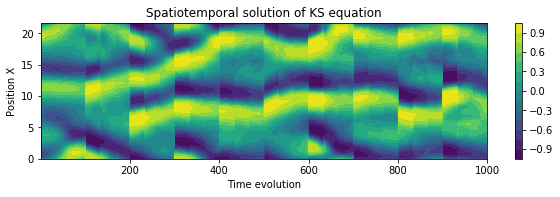

The true value


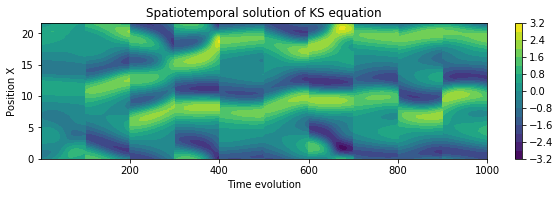

###################################
The prediction


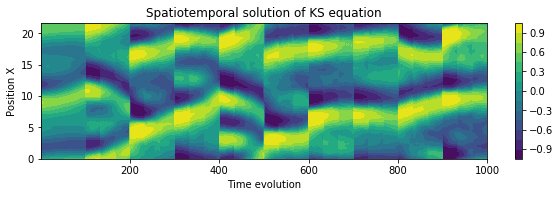

The true value


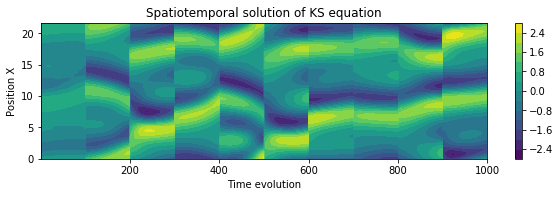

###################################
The prediction


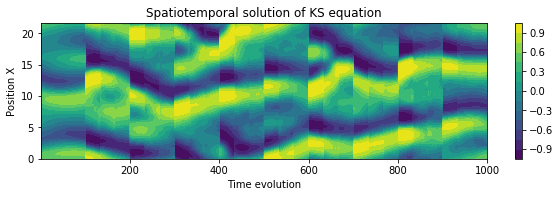

The true value


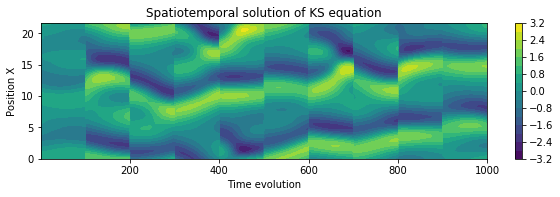

###################################
The prediction


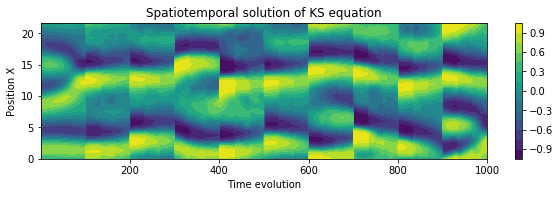

The true value


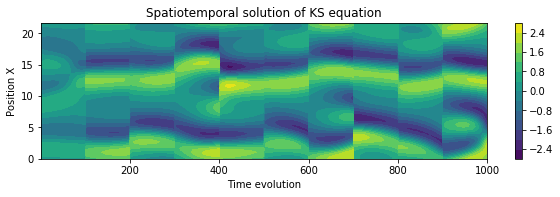

###################################
The prediction


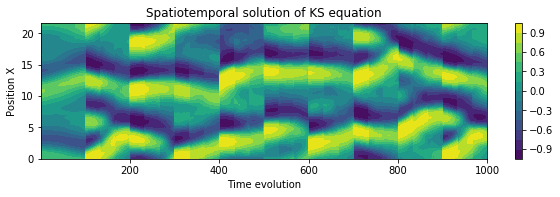

The true value


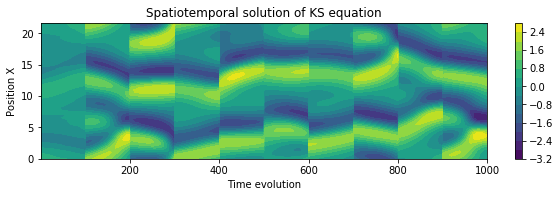

###################################
The prediction


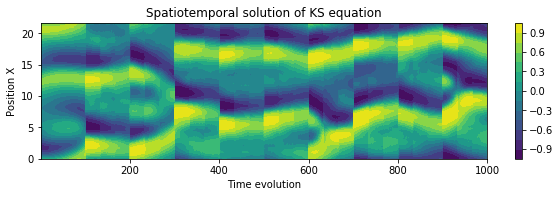

The true value


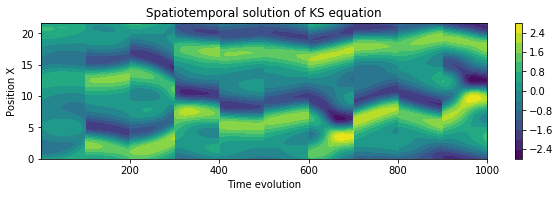

###################################
The prediction


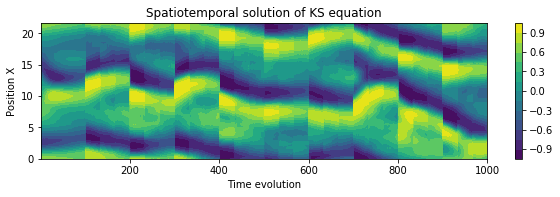

The true value


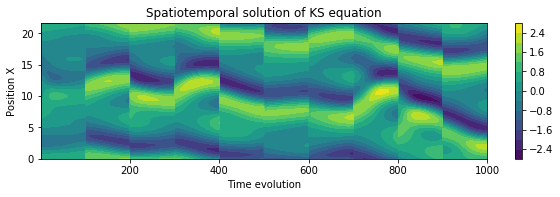

###################################
The prediction


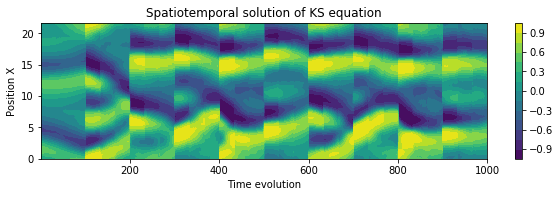

The true value


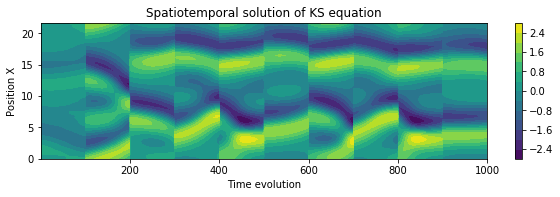

###################################
The prediction


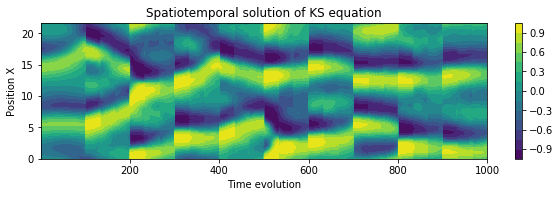

The true value


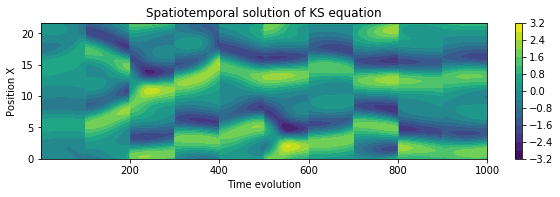

###################################
The prediction


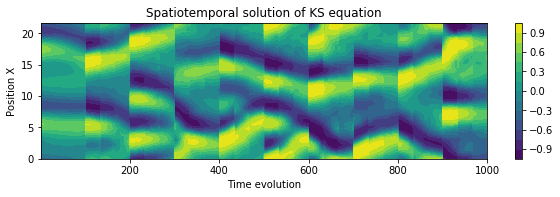

The true value


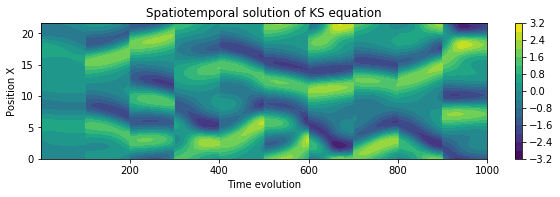

###################################
The prediction


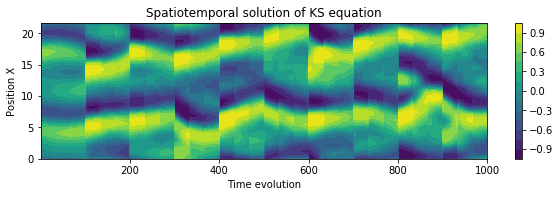

The true value


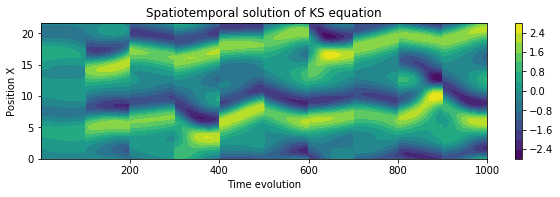

###################################
The prediction


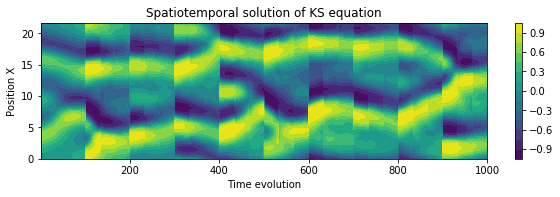

The true value


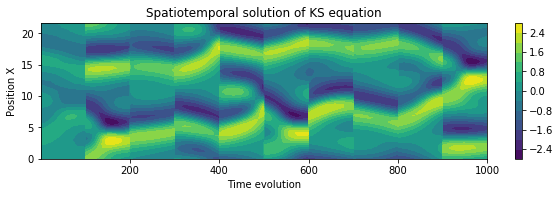

###################################
The prediction


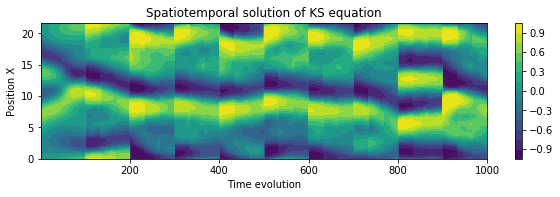

The true value


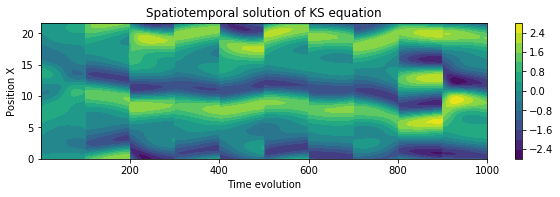

###################################
The prediction


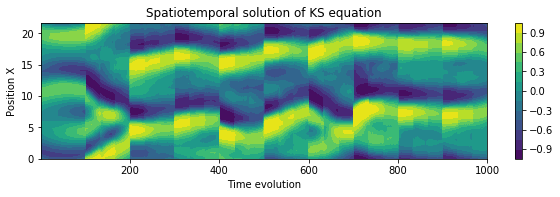

The true value


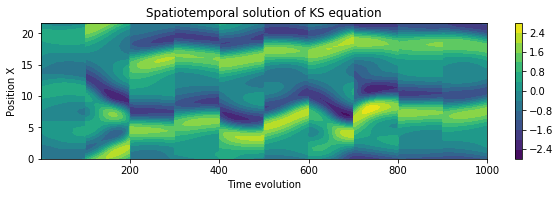

###################################
The prediction


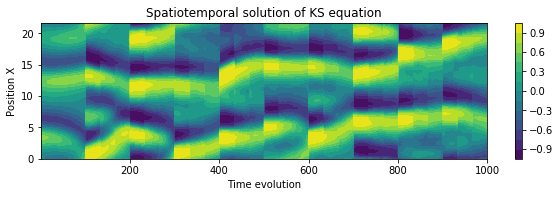

The true value


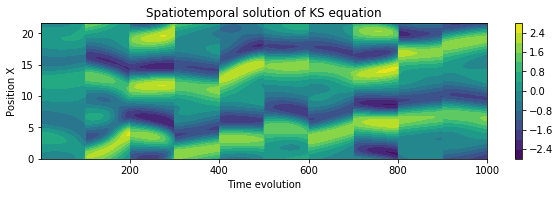

###################################
The prediction


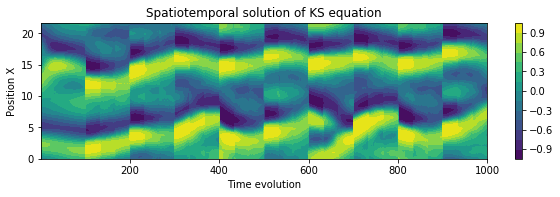

The true value


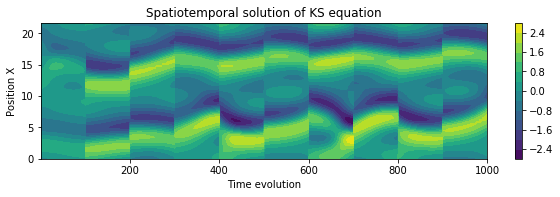

###################################
The prediction


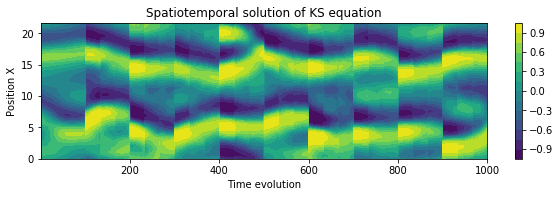

The true value


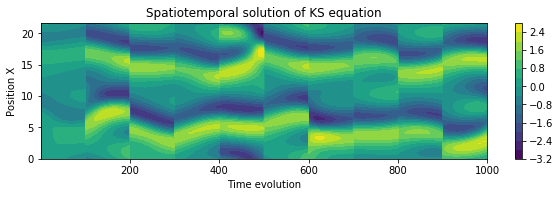

###################################
The prediction


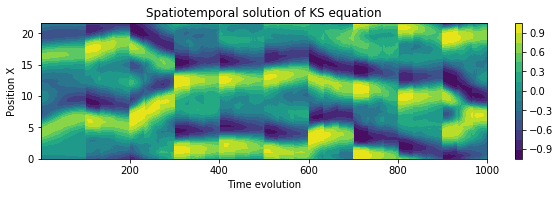

The true value


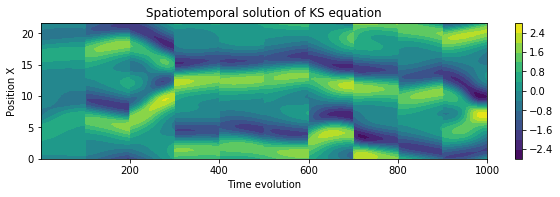

###################################
The prediction


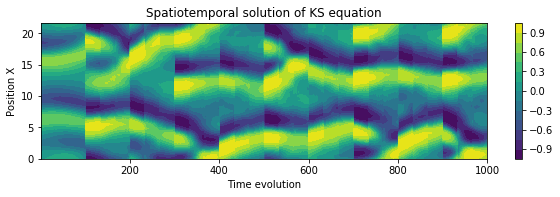

The true value


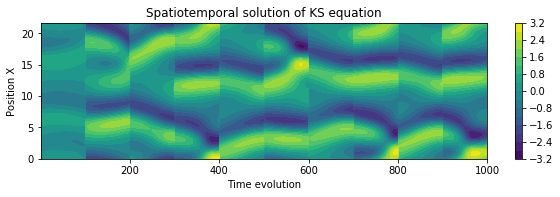

###################################
The prediction


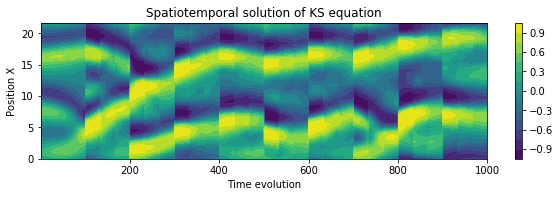

The true value


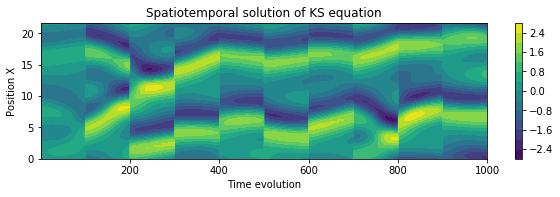

###################################
The prediction


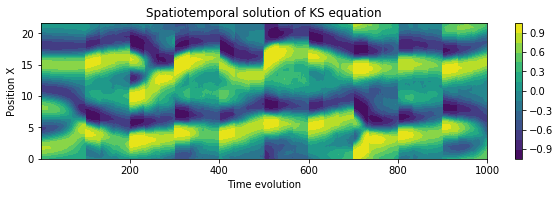

The true value


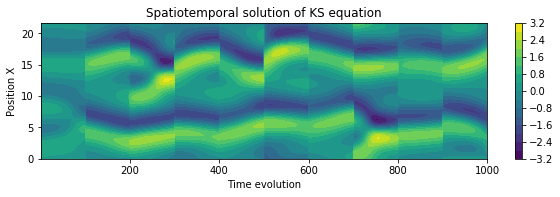

###################################
The prediction


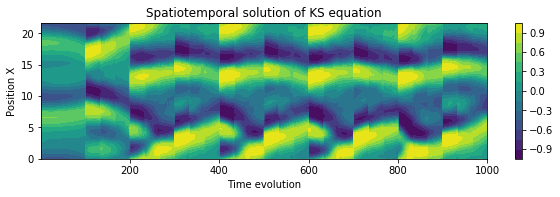

The true value


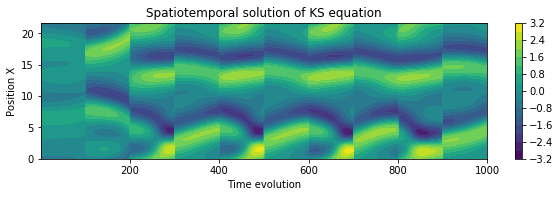

###################################
The prediction


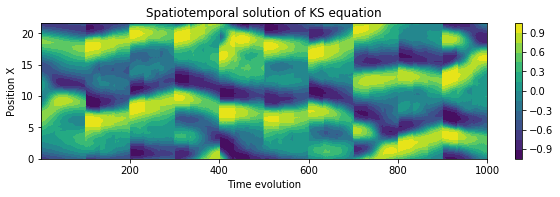

The true value


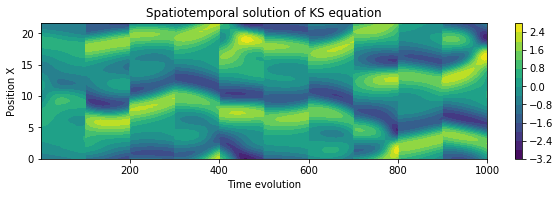

###################################
The prediction


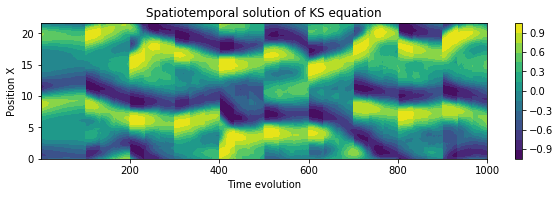

The true value


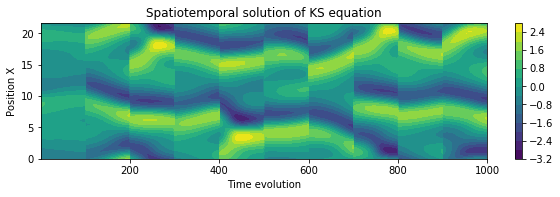

###################################
The prediction


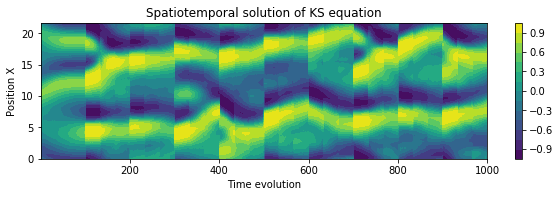

The true value


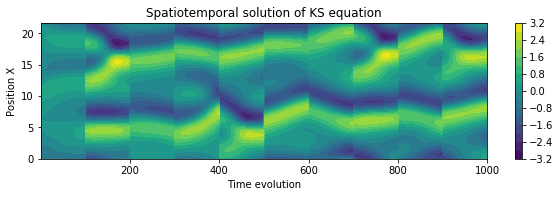

###################################
The prediction


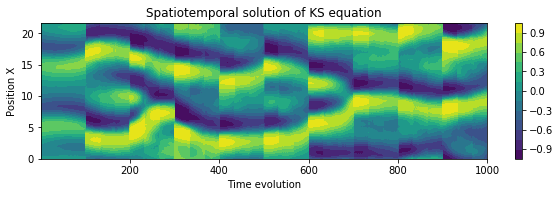

The true value


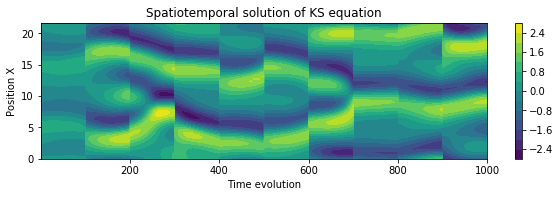

###################################
The prediction


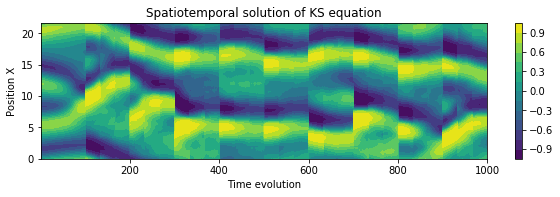

The true value


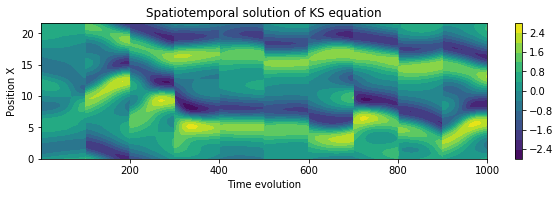

###################################
The prediction


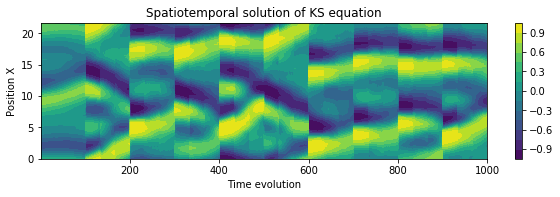

The true value


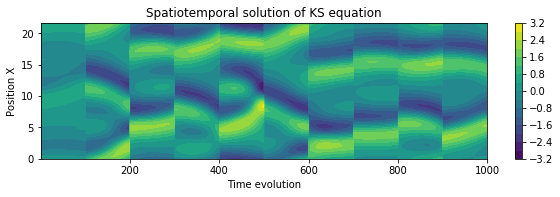

###################################
The prediction


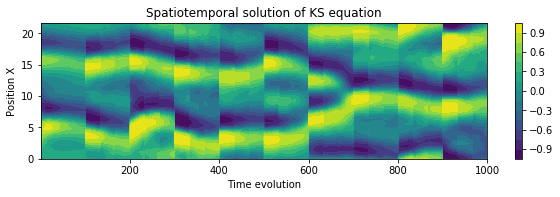

The true value


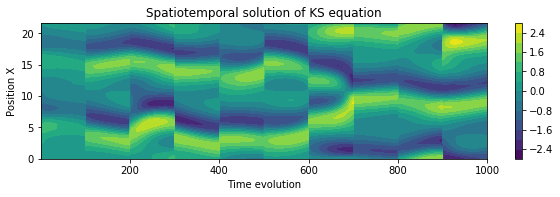

###################################
The prediction


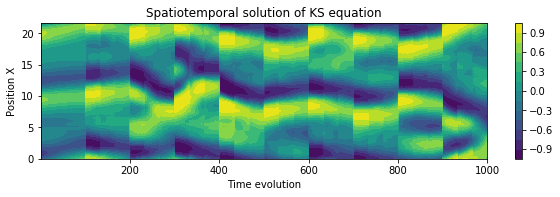

The true value


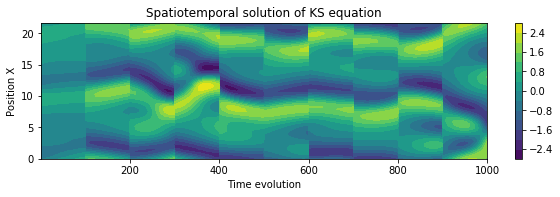

###################################
The prediction


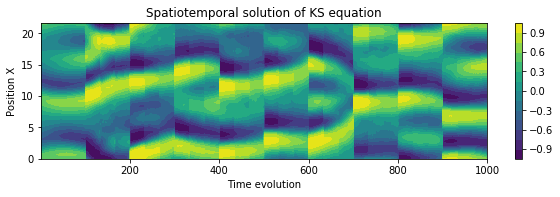

The true value


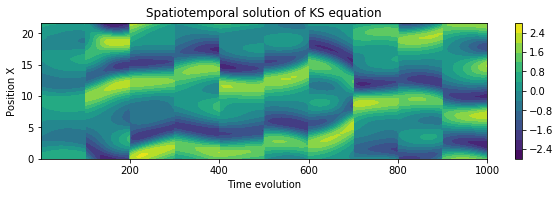

###################################
The prediction


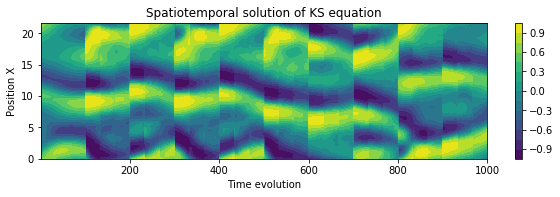

The true value


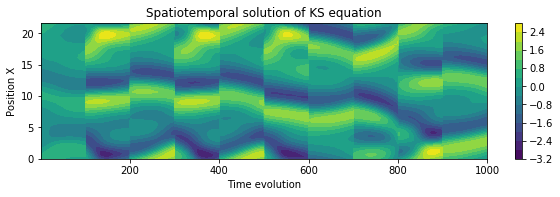

###################################
The prediction


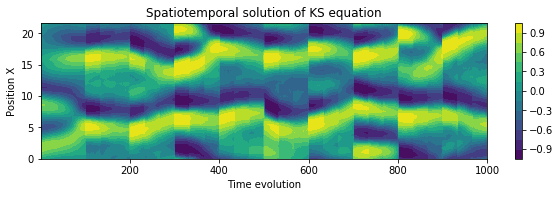

The true value


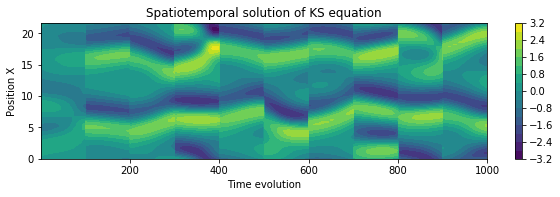

###################################
The prediction


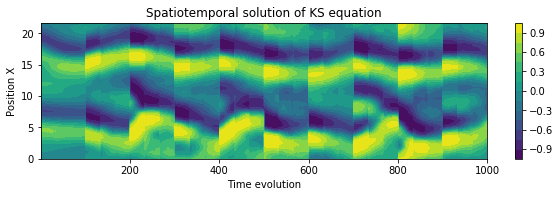

The true value


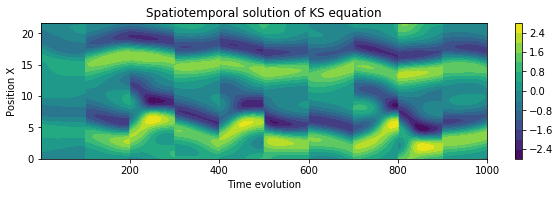

###################################
The prediction


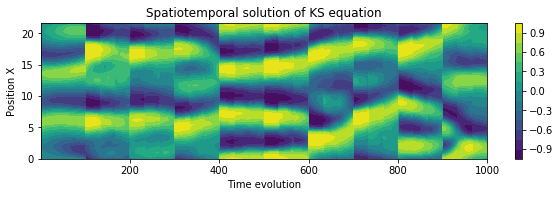

The true value


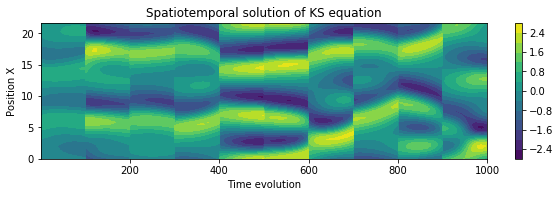

###################################
The prediction


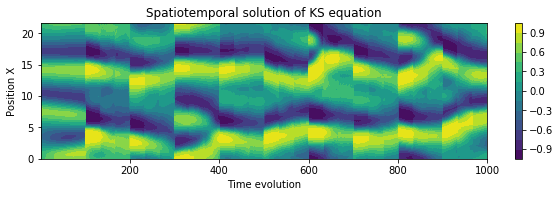

The true value


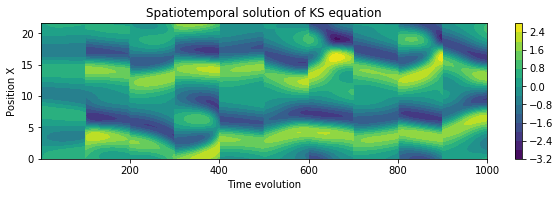

###################################
The prediction


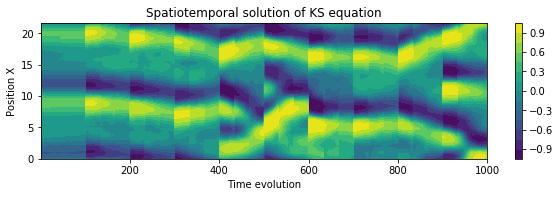

The true value


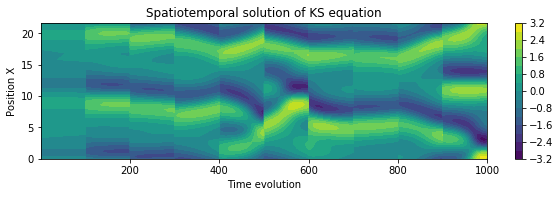

###################################
The prediction


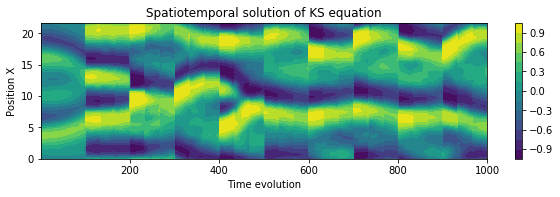

The true value


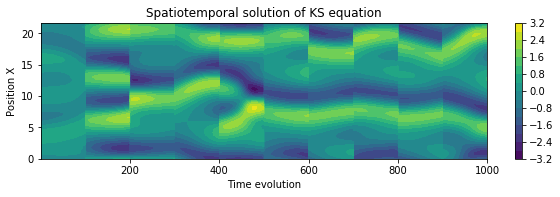

###################################
The prediction


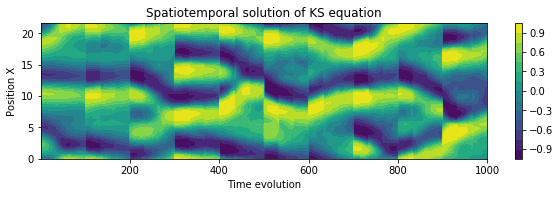

The true value


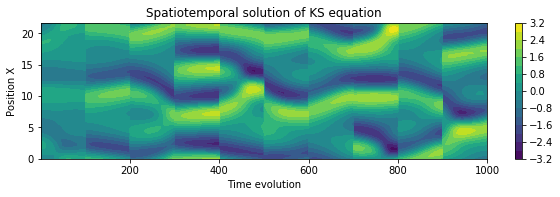

###################################
The prediction


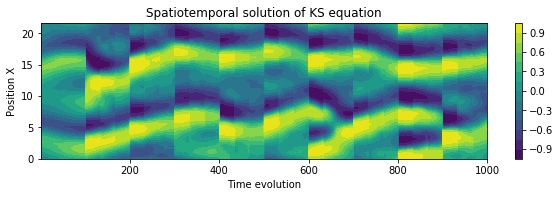

The true value


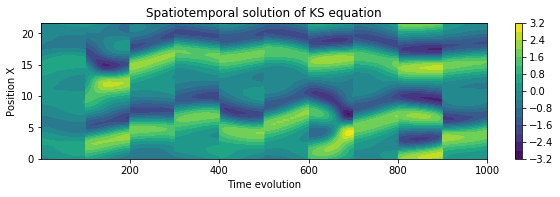

###################################
The prediction


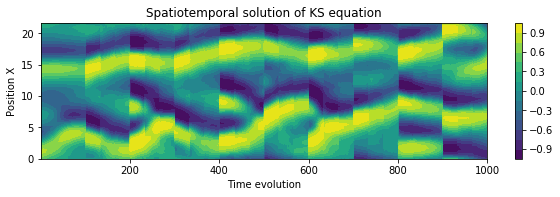

The true value


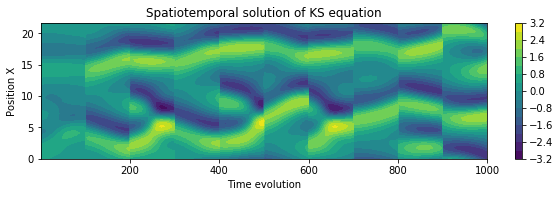

###################################
The prediction


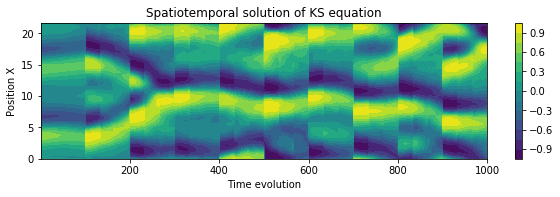

The true value


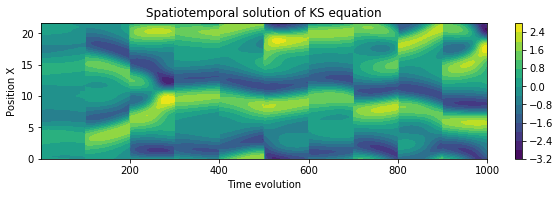

###################################
The prediction


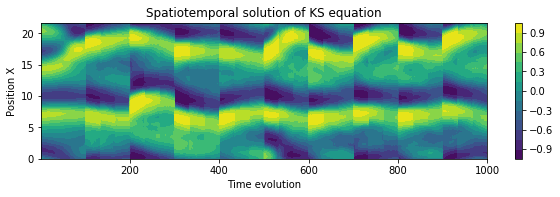

The true value


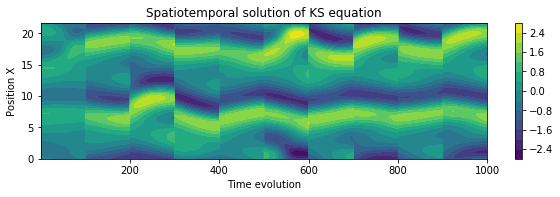

###################################
The prediction


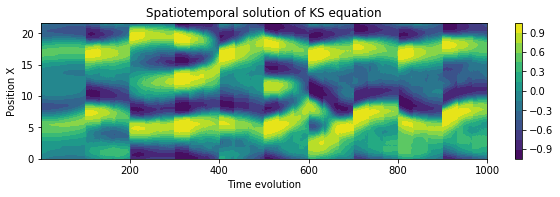

The true value


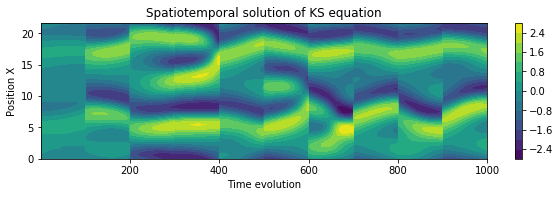

###################################
The prediction


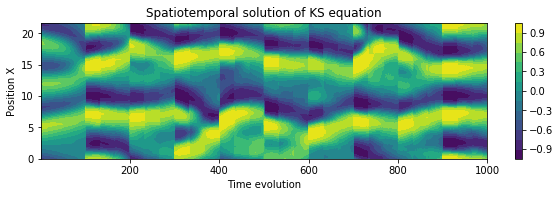

The true value


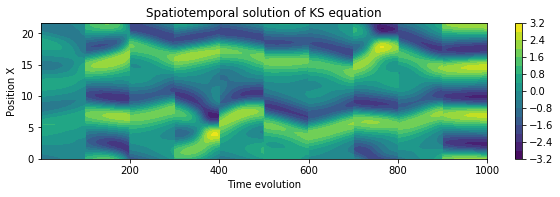

###################################
The prediction


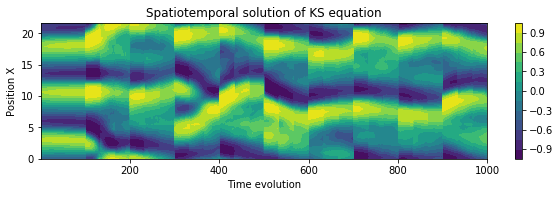

The true value


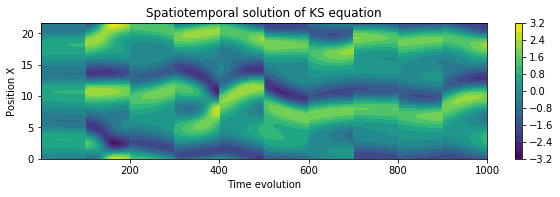

###################################
The prediction


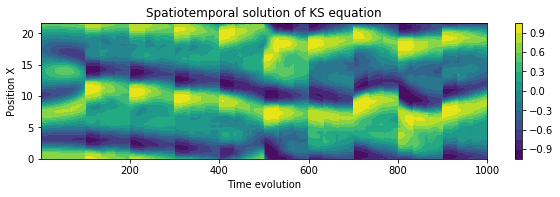

The true value


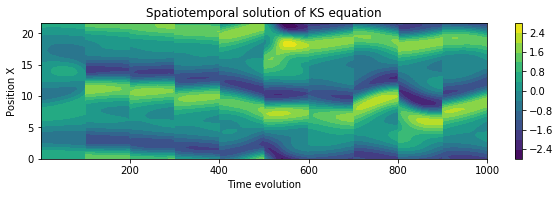

###################################
The prediction


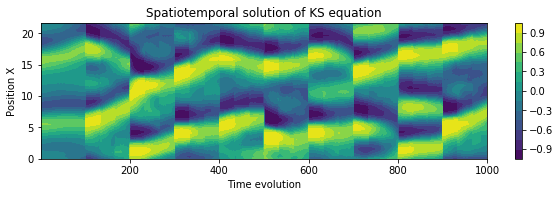

The true value


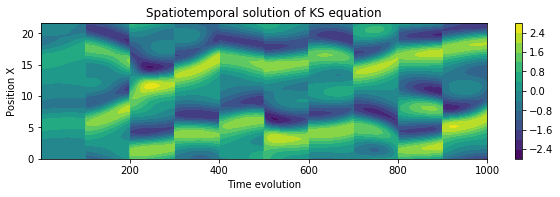

###################################
The prediction


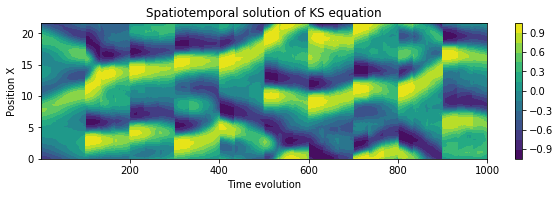

The true value


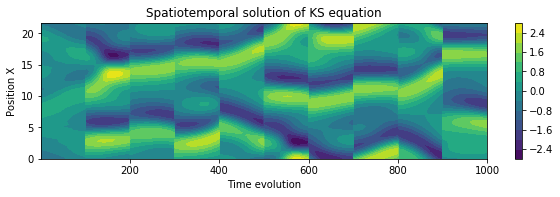

###################################
The prediction


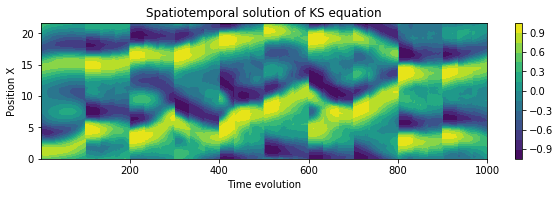

The true value


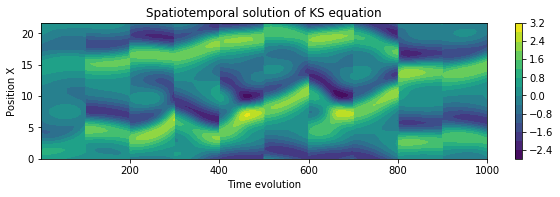

###################################
The prediction


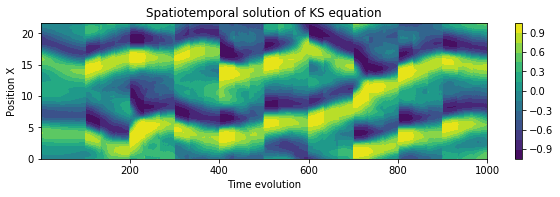

The true value


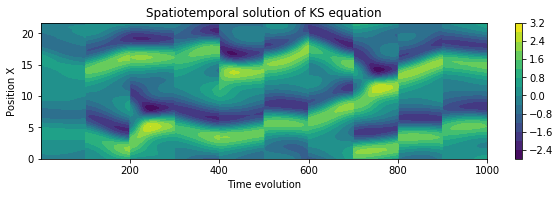

###################################
The prediction


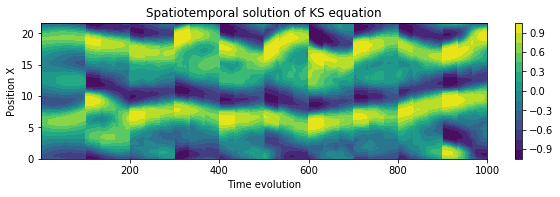

The true value


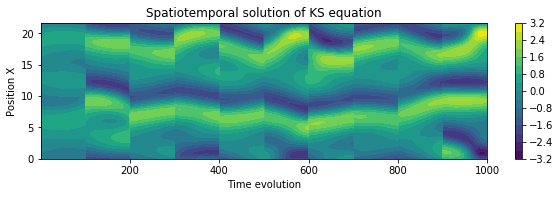

###################################
The prediction


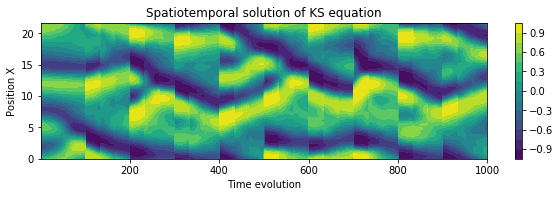

The true value


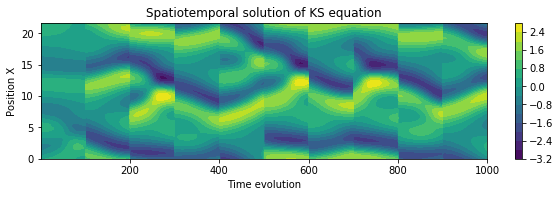

###################################
The prediction


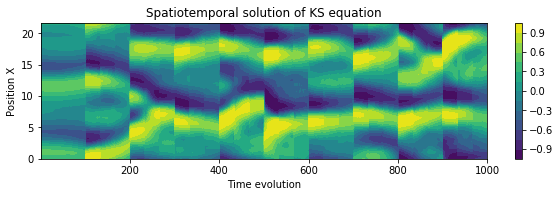

The true value


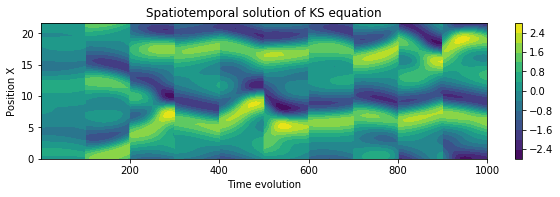

###################################
The prediction


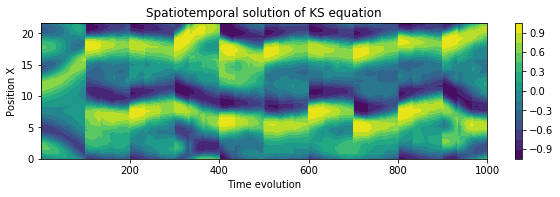

The true value


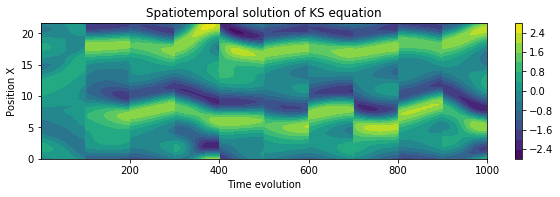

###################################
The prediction


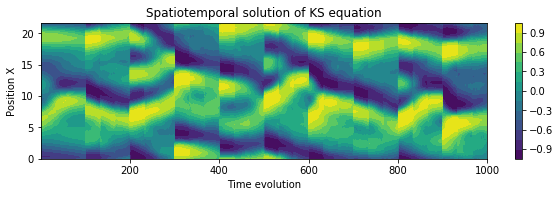

The true value


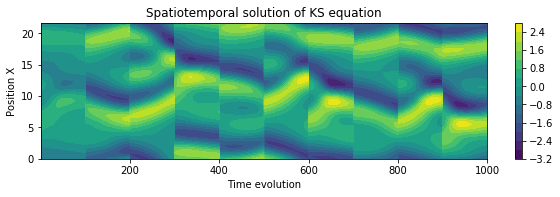

###################################
The prediction


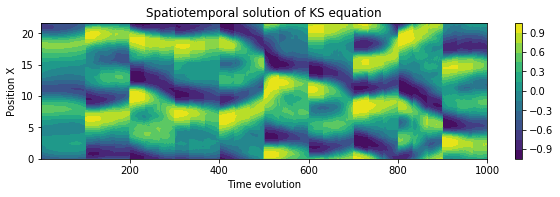

The true value


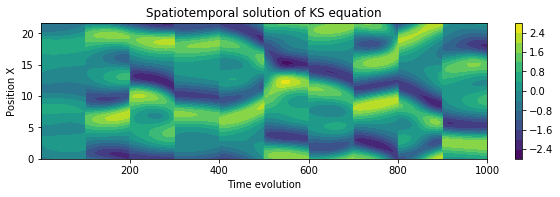

###################################
The prediction


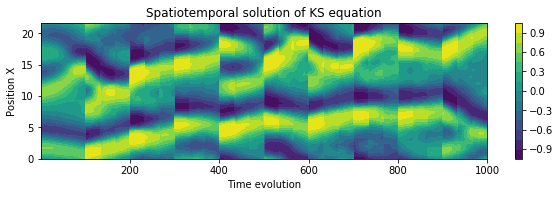

The true value


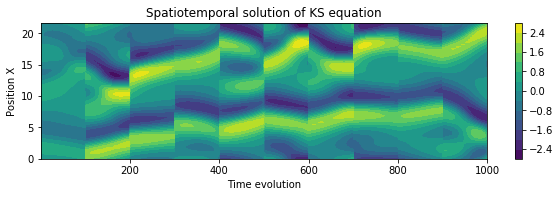

###################################
The prediction


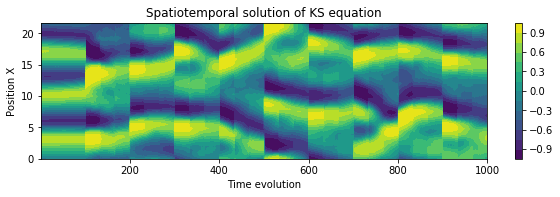

The true value


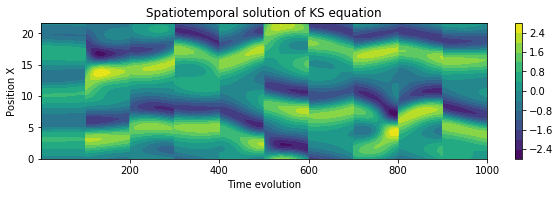

###################################
The prediction


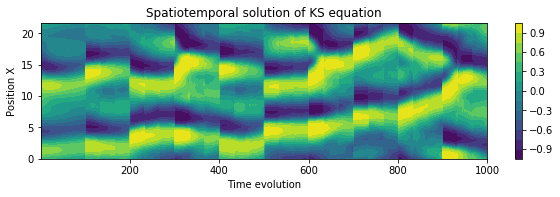

The true value


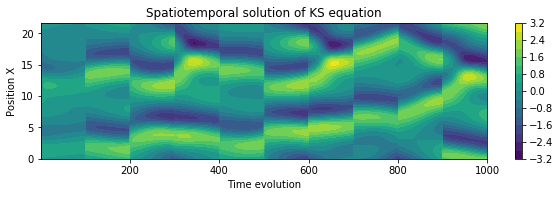

###################################
The prediction


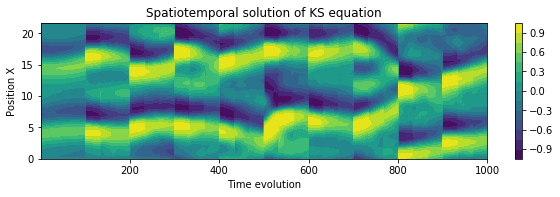

The true value


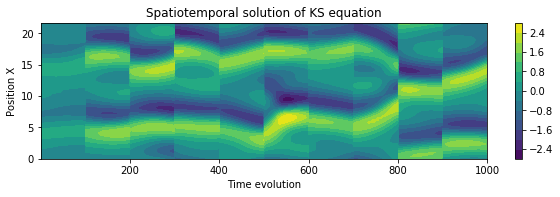

###################################
The prediction


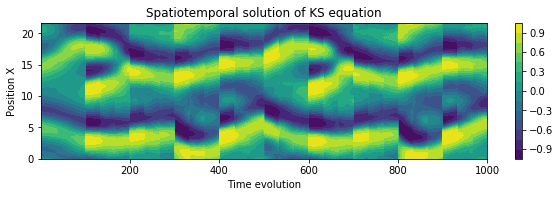

The true value


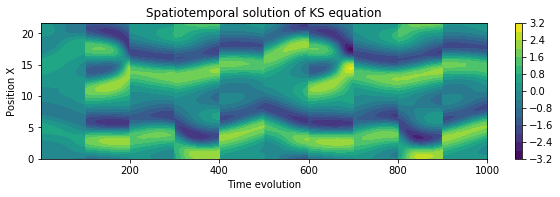

###################################
The prediction


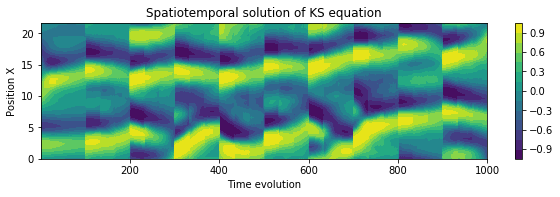

The true value


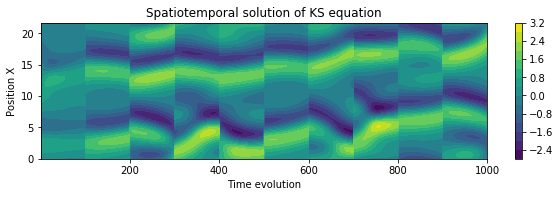

###################################
The prediction


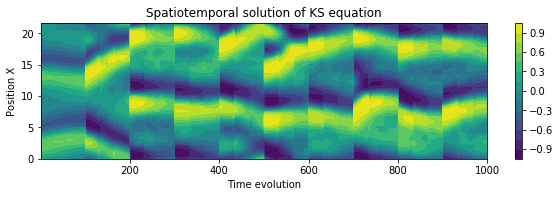

The true value


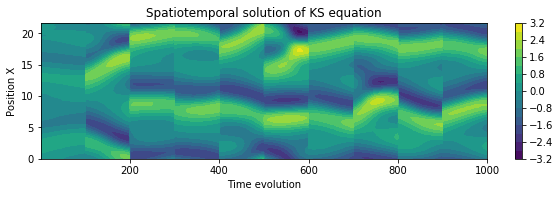

###################################
The prediction


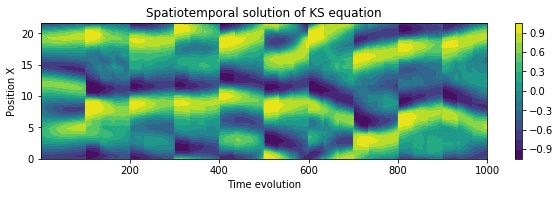

The true value


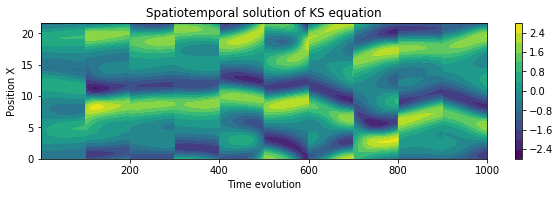

###################################
The prediction


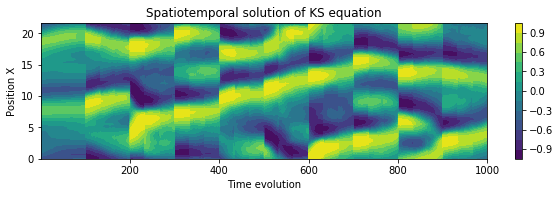

The true value


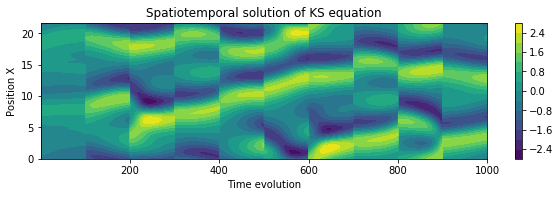

###################################
The prediction


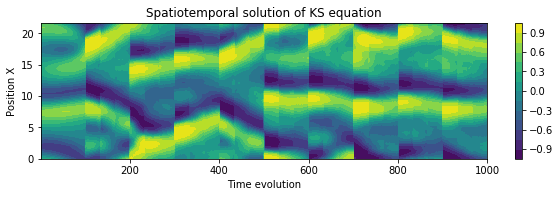

The true value


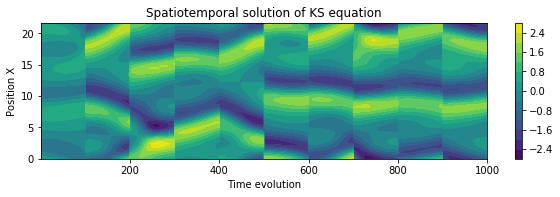

###################################
The prediction


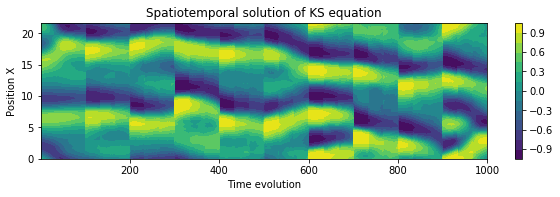

The true value


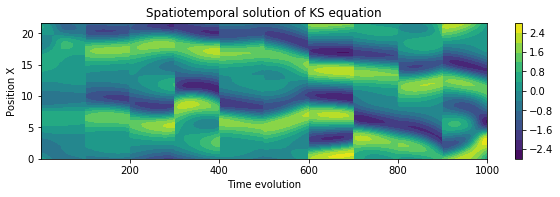

###################################
The prediction


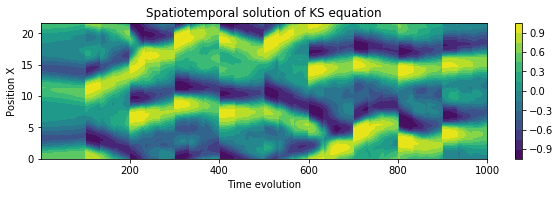

The true value


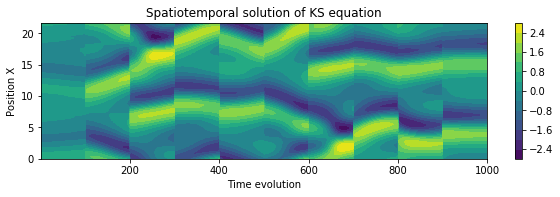

###################################
The prediction


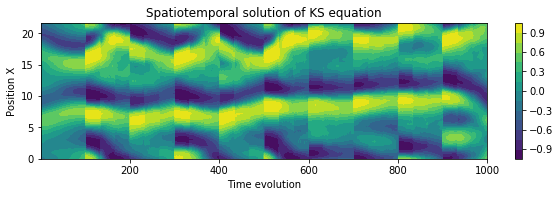

The true value


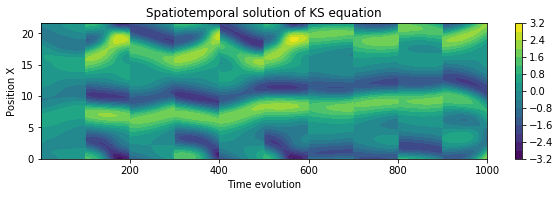

###################################
The prediction


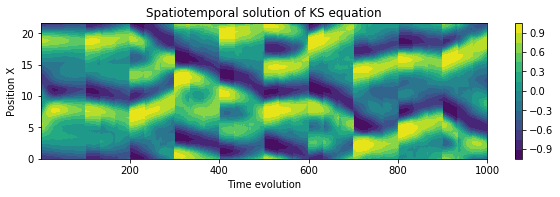

The true value


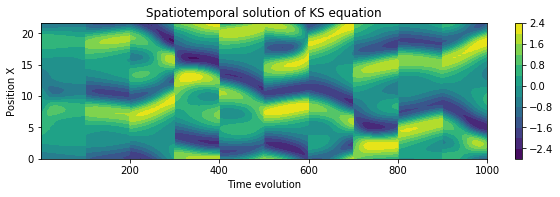

###################################
The prediction


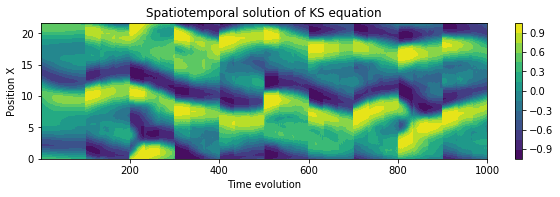

The true value


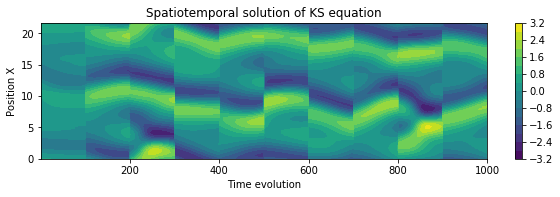

###################################
The prediction


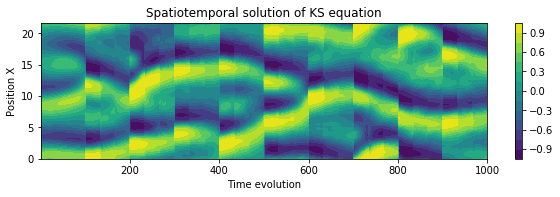

The true value


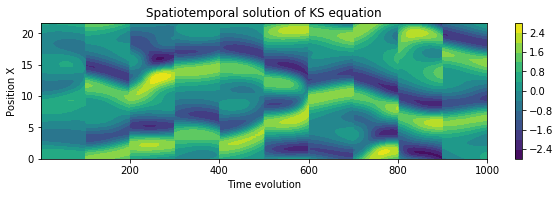

###################################
The prediction


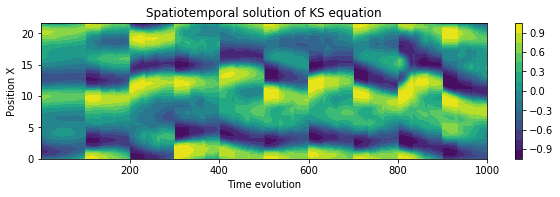

The true value


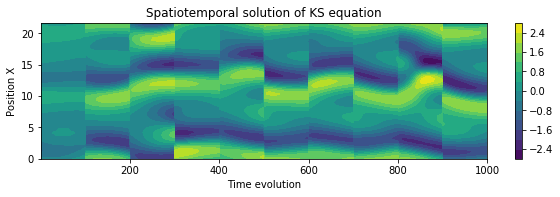

###################################
The prediction


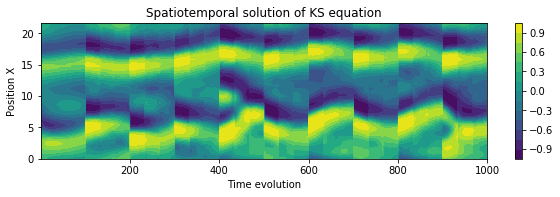

The true value


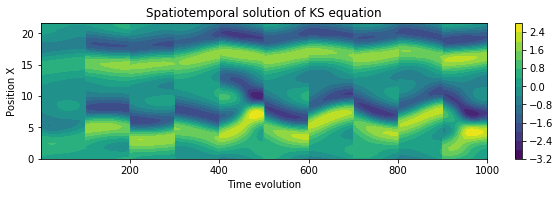

###################################
The prediction


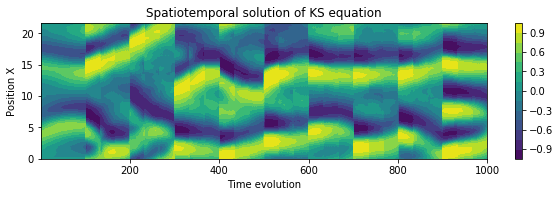

The true value


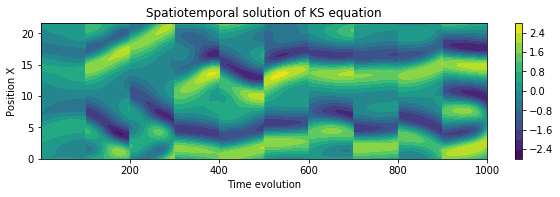

###################################
The prediction


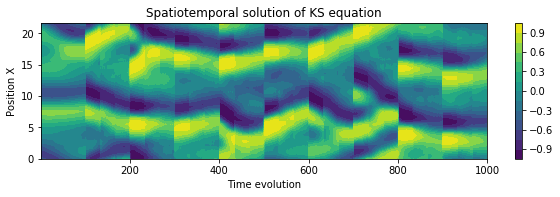

The true value


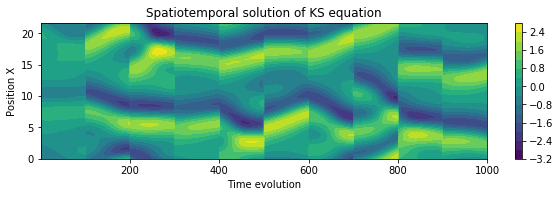

###################################
The prediction


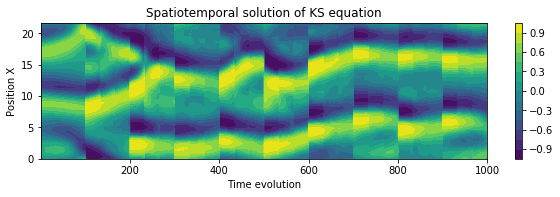

The true value


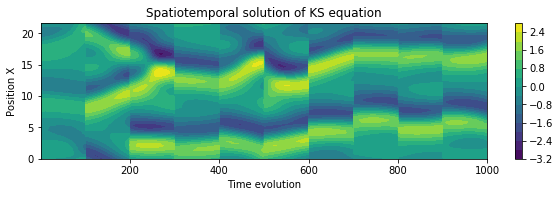

###################################
The prediction


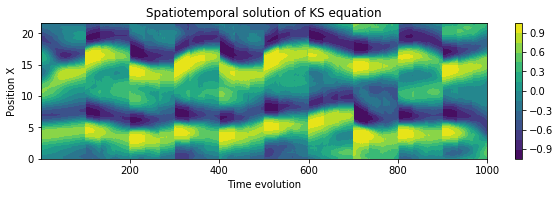

The true value


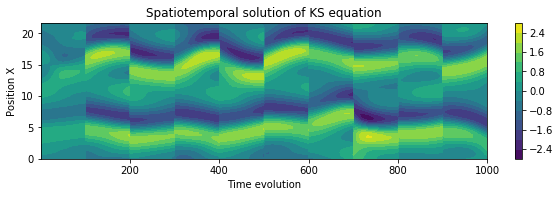

###################################
The prediction


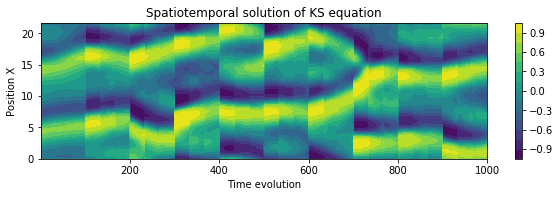

The true value


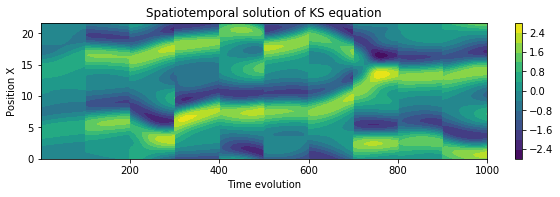

###################################
The prediction


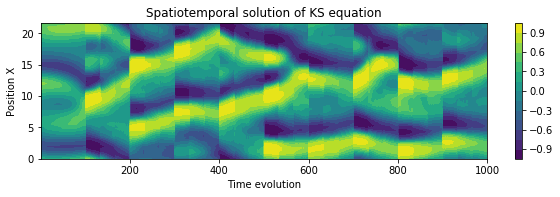

The true value


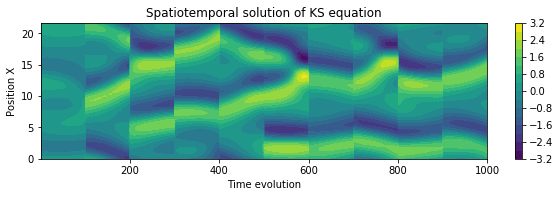

###################################
The prediction


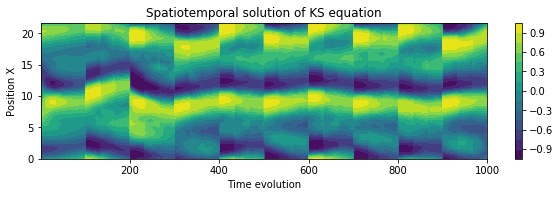

The true value


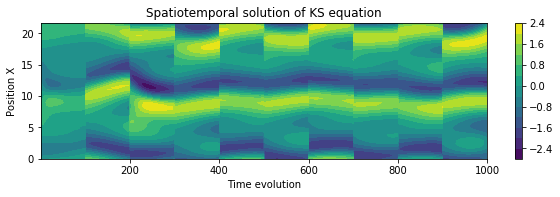

###################################
The prediction


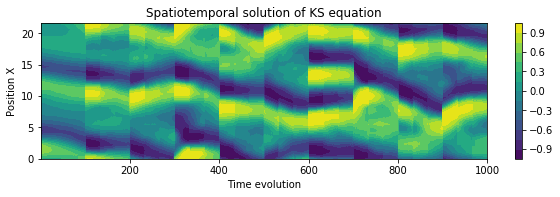

The true value


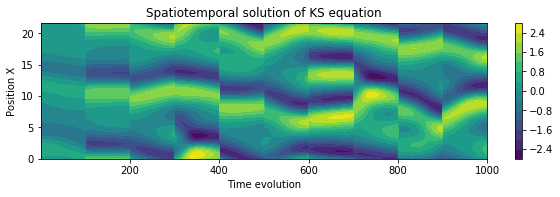

###################################
The prediction


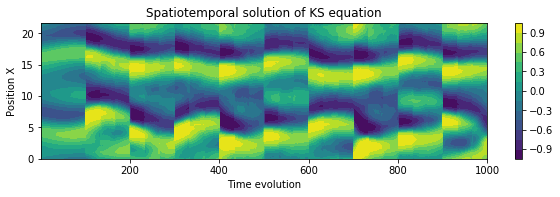

The true value


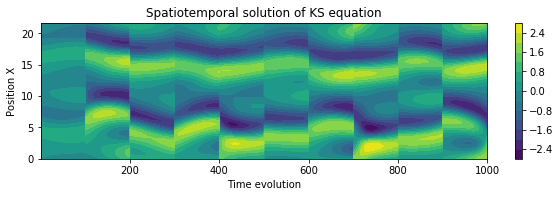

###################################
The prediction


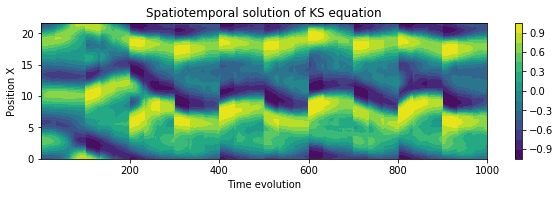

The true value


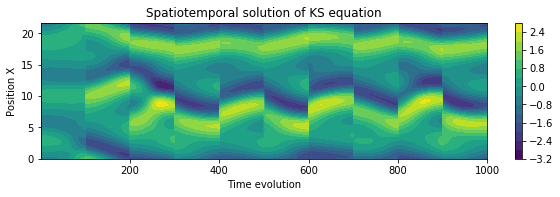

###################################


In [180]:
#KSflow
for i in range(100):
    print('The prediction')
    drawKS(statespred1[:,:,i], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
    print('The true value')
    drawKS(statespred2[:,:,i], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
    print("###################################")

The prediction


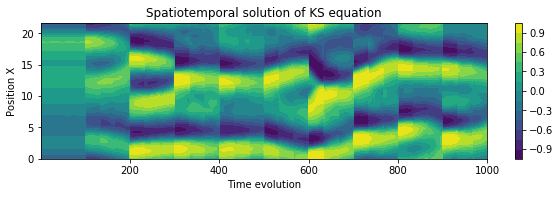

The true value


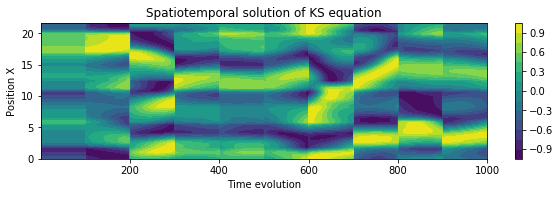

In [205]:
time_counter=np.linspace(0,1000,1500)
#KSflow
print('The prediction')
drawKS(statespred1[:,:,0], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
print('The true value')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
statespred2[:,:,0] = min_max_scaler.fit_transform(statespred2[:,:,0)
drawKS(statespred2[:,:,0], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)

I think that it is necessary to normalize the data of the simulator:

In [194]:
for ii in range(start_positions_1.shape[0]):
    pos_1=int(start_positions_1[ii])
    pos_2=int(start_positions_2[ii])
    N_step_simu=int(total_prediction/steps_to_predict)
    vvv=int(size_conv_time/steps_to_predict)
    for i in range(int(N_step_simu/vvv)):
        if i==0:
            pp1,yy1,dif1 = prediction(model,pos_1,vvv,steps_to_predict,size_conv_time,state_history_norm_th)
            pp2,yy2,dif2 = prediction(model,pos_2,vvv,steps_to_predict,size_conv_time,state_history_norm_th)
            delta_all_models_1[0,i*steps_to_predict:(i+1)*steps_to_predict*vvv,ii] = dif1
            delta_all_models_2[0,i*steps_to_predict:(i+1)*steps_to_predict*vvv,ii] = dif2
            statespred1[0:size_conv_time,:,ii]=pp1
            statespred2[0:size_conv_time,:,ii]=yy1
            
        else:
            pos_1 = size_conv_time
            pos_2 = size_conv_time
            state_history1, time_counter, position_x = generatingdata(pp1[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)
            state_history2, time_counter, position_x = generatingdata(pp2[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)            
            state_history1 = th.from_numpy(state_history1)
            state_history2 = th.from_numpy(state_history2)
            
            #normalizing the data generated:
            min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
            state_history1 = min_max_scaler.fit_transform(state_history1)
            state_history2 = min_max_scaler.fit_transform(state_history2)
            
            state_history1 = th.from_numpy(state_history1)
            state_history2 = th.from_numpy(state_history2)
            pp1,yy1,dif1 = prediction(model,pos_1,vvv,steps_to_predict,size_conv_time,state_history1)
            pp2,yy2,dif2 = prediction(model,pos_2,vvv,steps_to_predict,size_conv_time,state_history2)

            delta_all_models_1[0,i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,ii] = dif1
            delta_all_models_2[0,i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,ii] = dif2
            statespred1[i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,:,ii]=pp1
            statespred2[i*steps_to_predict*vvv:(i+1)*steps_to_predict*vvv,:,ii]=yy1
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

Text(0.5, 0, 'Initial position')

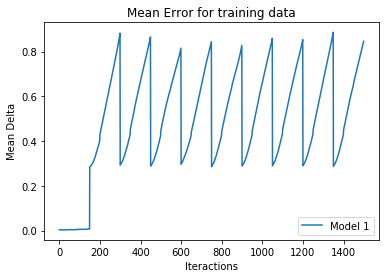

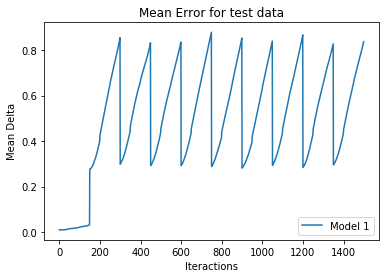

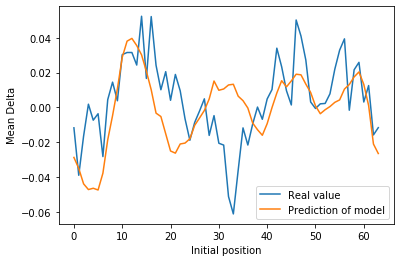

In [195]:
plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d1[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for training data')

plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d2[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('Mean Delta')
plt.xlabel('Iteractions')
plt.title('Mean Error for test data')

n1 = np.mean(statespred1,axis=0)
n1 = np.mean(n1,axis=1)
n11 = np.mean(statespred2,axis=0)
n11 = np.mean(n11,axis=1)

plt.figure()

plt.plot(n1)
plt.plot(n11)
plt.legend(['Real value','Prediction of model'])
plt.ylabel('Mean Delta')
plt.xlabel('Initial position')

The prediction:


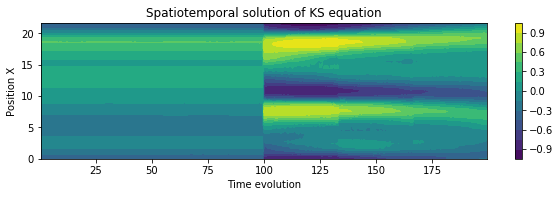

The true value:


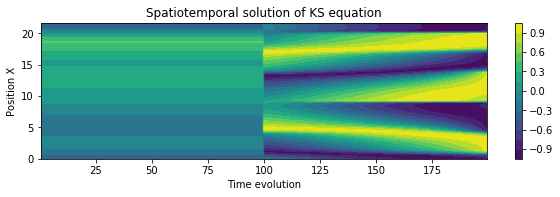

In [196]:
time_counter=np.linspace(0,1000,1500)
#KSflow
print('The prediction:')
drawKS(statespred1[:,:,0], position_x, time_counter ,startT=1,endT=300, width = 10, divwidth = 4)
print('The true value:')
drawKS(statespred2[:,:,0], position_x, time_counter ,startT=1,endT=300, width = 10, divwidth = 4)